# Quick start guide
This notebook serves as an example of how to train a simple model using pytorch and the ready-to-train AI4Arctic challenge dataset. Initially, a dictionary, 'train_options', is set up with relevant options for both the example U-Net Convolutional Neural Network model and the dataloader. Note that the weights of the U-Net will be initialised at random and therefore not deterministic - results will vary for every training run. Two lists (dataset.json and testset.json) include the names of the scenes relevant to training and testing, where the former can be altered if desired. Training data is loaded in parallel using the build-in torch Dataset and Dataloader classes, and works by randomly sampling a scene and performing a random crop to extract a patch. Each batch will then be compiled of X number of these patches with the patch size in the 'train_options'. An obstacle is different grid resolution sizes, which is overcome by upsampling low resolution variables, e.g. AMSR2, ERA5, to match the SAR pixels. A number of batches will be prepared in parallel and stored until use, depending on the number of workers (processes) spawned (this can be changed in 'num_workers' in 'train_options'). The model is trained on a fixed number of steps according to the number of batches in an epoch, defined by the 'epoch_len' parameter, and will run for a total number of epochs depending on the 'epochs' parameter. After each epoch, the model is evaluated. In this example, a random number of scenes are sampled among the training scenes (and removed from the list of training scenes) to act as a validation set used for the evaluation. The model is evaluated with the metrics, and if the current validation attempt is superior to the previous, then the model parameters are stored in the 'best_model' file in the directory.

The models are scored on the three sea ice parameters; Sea Ice Concentration (SIC), Stage of Development (SOD) and the Floe size (FLOE) with the $R²$ metric for the SIC, and the weighted F1 metric for the SOD and FLOE. The 3 scores are combined into a single metric by taking the weighted average with SIC and SOD being weighted with 2 and the FLOE with 1.

Finally, once you are ready to test your model on the test scenes (without reference data), the 'test_upload' notebook will produce model outputs with your model of choice and save the output as a netCDF file, which can be uploaded to the AI4EO.eu website. The model outputs will be evaluated and then you will receive a score. 

This quick start notebook is by no means necessary to utilize, and you are more than welcome to develop your own data pipeline. We do however require that the model output is stored in a netcdf file with xarray.dataarrays titled '{scene_name}_{chart}', i.e. 3 charts per scene / file (see how in 'test_upload'). In addition, you are more than welcome to create your own preprocessing scheme to prepare the raw AI4Arctic challenge dataset. However, we ask that the model output is in 80 m pixel spacing (original is 40 m), and that you follow the class numberings from the lookup tables in 'utils' - at least you will be evaluated in this way. Furthermore, we have included a function to convert the polygon_icechart to SIC, SOD and FLOE, you will have to incorporate it yourself.

The first cell imports the necessary Python packages, initializes the 'train_options' dictionary, the sample U-Net options, loads the dataset list and select validation scenes.

In [1]:
# -- Built-in modules -- #
import gc
import os
import sys

# -- Environmental variables -- #
os.environ['AI4ARCTIC_DATA'] = 'C:\\Users\\Ultimate Gaming Comp\\Documents\\Ice_Data'  # Fill in directory for data location.
os.environ['AI4ARCTIC_ENV'] = 'C:\\Users\\Ultimate Gaming Comp\\Documents\\Ice_Challenge\AI4ArcticSeaIceChallenge'  # Fill in directory for environment with Ai4Arctic get-started package.


In [2]:
# -- Third-part modules -- #
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import xarray as xr
from tqdm.notebook import tqdm  # Progress bar

# --Proprietary modules -- #
from functions import chart_cbar, r2_metric, f1_metric, compute_metrics  # Functions to calculate metrics and show the relevant chart colorbar.
from loaders import AI4ArcticChallengeDataset, AI4ArcticChallengeTestDataset, get_variable_options  # Custom dataloaders for regular training and validation.
from unet import UNet  # Convolutional Neural Network model
from utils import CHARTS, SIC_LOOKUP, SOD_LOOKUP, FLOE_LOOKUP, SCENE_VARIABLES, colour_str


train_options = {
    # -- Training options -- #
    'path_to_processed_data': os.environ['AI4ARCTIC_DATA'],  # Replace with data directory path.
    'path_to_env': os.environ['AI4ARCTIC_ENV'],  # Replace with environmment directory path.
    'lr': 0.0001,  # Optimizer learning rate.
    'epochs': 50,  # Number of epochs before training stop.
    'epoch_len': 500,  # Number of batches for each epoch.
    'patch_size': 256,  # Size of patches sampled. Used for both Width and Height.
    'batch_size': 8,  # Number of patches for each batch.
    'loader_upsampling': 'nearest',  # How to upscale low resolution variables to high resolution.
    
    # -- Data prepraration lookups and metrics.
    'train_variables': SCENE_VARIABLES,  # Contains the relevant variables in the scenes.
    'charts': CHARTS,  # Charts to train on.
    'n_classes': {  # number of total classes in the reference charts, including the mask.
        'SIC': SIC_LOOKUP['n_classes'],
        'SOD': SOD_LOOKUP['n_classes'],
        'FLOE': FLOE_LOOKUP['n_classes']
    },
    'pixel_spacing': 80,  # SAR pixel spacing. 80 for the ready-to-train AI4Arctic Challenge dataset.
    'train_fill_value': 0,  # Mask value for SAR training data.
    'class_fill_values': {  # Mask value for class/reference data.
        'SIC': SIC_LOOKUP['mask'],
        'SOD': SOD_LOOKUP['mask'],
        'FLOE': FLOE_LOOKUP['mask'],
    },
    
    # -- Validation options -- #
    'chart_metric': {  # Metric functions for each ice parameter and the associated weight.
        'SIC': {
            'func': r2_metric,
            'weight': 2,
        },
        'SOD': {
            'func': f1_metric,
            'weight': 2,
        },
        'FLOE': {
            'func': f1_metric,
            'weight': 1,
        },
    },
    'num_val_scenes': 10,  # Number of scenes randomly sampled from train_list to use in validation.
    
    # -- GPU/cuda options -- #
    'gpu_id': 0,  # Index of GPU. In case of multiple GPUs.
    'num_workers': 2,  # Number of parallel processes to fetch data.
    'num_workers_val': 1,  # Number of parallel processes during validation.
    
    # -- U-Net Options -- #
    'unet_conv_filters': [16, 32, 64, 64],  # Number of filters in the U-Net.
    'conv_kernel_size': (3, 3),  # Size of convolutional kernels.
    'conv_stride_rate': (1, 1),  # Stride rate of convolutional kernels.
    'conv_dilation_rate': (1, 1),  # Dilation rate of convolutional kernels.
    'conv_padding': (1, 1),  # Number of padded pixels in convolutional layers.
    'conv_padding_style': 'zeros',  # Style of padding.
}
# Get options for variables, amsrenv grid, cropping and upsampling.
get_variable_options = get_variable_options(train_options)
# To be used in test_upload.
%store train_options




# # Load training list.
# with open(train_options['path_to_env'] + '/datalists/dataset.json') as file:
#     train_options['train_list'] = json.loads(file.read())
# # Convert the original scene names to the preprocessed names.
# train_options['train_list'] = [file[17:32] + '_' + file[77:80] + '_prep.nc' for file in train_options['train_list']]



import glob
train_options['train_list'] = glob.glob('C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2/*')
#print(train_options)





# Select a random number of validation scenes with the same seed. Feel free to change the seed.et
np.random.seed(0)
train_options['validate_list'] = np.random.choice(np.array(train_options['train_list']), size=train_options['num_val_scenes'], replace=False)
# Remove the validation scenes from the train list.
train_options['train_list'] = [scene for scene in train_options['train_list'] if scene not in train_options['validate_list']]
print('Options initialised')


Stored 'train_options' (dict)
Options initialised


In [36]:
# curriculum learning, three dataloaders derived from lists of images, first loader good images, second loader less good, third loader very poorly defined ice edges and artifacts, datasets need to be manually curated
# for now, sample 3 x 300 random to check architecture
# scores not to be trusted until data actually binned



# Theoretical way to actually load different quality lists from json
# Load curriculum training list.

'''

with open(train_options['path_to_env'] + '\ecaies_batches.json') as file:
    quality_labels = json.loads(file.read())

batch_1_good = quality_labels['High_quality']
batch_2_moderate = quality_labels['Moderate_quality']
batch_3_bad = quality_labels['Low_quality']

'''




batch_1_good = np.random.choice(train_options['train_list'], size= 300)
batch_2_moderate = np.random.choice(train_options['train_list'], size= 300)
batch_3_bad = np.random.choice(train_options['train_list'], size= 300)


In [37]:
batch_1_good

array(['C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20180213T202018_dmi_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20211105T193931_dmi_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20190411T102726_cis_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20200124T102428_dmi_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20200706T203552_dmi_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20201012T175522_dmi_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20210521T082226_dmi_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20210402T203557_dmi_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20181028T114204_cis_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20211124T193116_dmi_prep.nc',
       'C:/Users/Ultimate Gaming Comp/Documents/Ice_Data_2\\20210519T115303_dmi_prep.nc',
       'C:

### CUDA / GPU Setup
This sets up the 'device' variable containing GPU information, and the custom dataset and dataloader.

In [9]:
# Get GPU resources.
if torch.cuda.is_available():
    print(colour_str('GPU available!', 'green'))
    print('Total number of available devices: ', colour_str(torch.cuda.device_count(), 'orange'))
    device = torch.device(f"cuda:{train_options['gpu_id']}")

else:
    print(colour_str('GPU not available.', 'red'))
    device = torch.device('cpu')



train_options['train_variables'] = [

    # -- Sentinel-1 variables -- #
    'nersc_sar_primary',
    'nersc_sar_secondary',
    'sar_incidenceangle',

    # -- Geographical variables -- #
    'distance_map',

    # -- AMSR2 channels -- #
    'btemp_6_9h'

    # 'btemp_6_9h', 'btemp_6_9v',
    # 'btemp_7_3h', 'btemp_7_3v',
    # 'btemp_10_7h', 'btemp_10_7v',
    # 'btemp_18_7h', 'btemp_18_7v',
    # 'btemp_23_8h', 'btemp_23_8v',
    # 'btemp_36_5h', 'btemp_36_5v',
    # 'btemp_89_0h', 'btemp_89_0v',

    # -- Environmental variables -- #
    # 'u10m_rotated', 'v10m_rotated',
    # 't2m', 'skt', 'tcwv', 'tclw'
    ]


print('GPU and data setup complete.')






GPU available!
Total number of available devices:  1
GPU and data setup complete.


In [25]:
# Custom dataset and dataloader based on the three bins of data quality we have, these are trained sequentially


batch_1_dataset = AI4ArcticChallengeDataset(files=batch_1_good, options=train_options, force_selection= train_options['train_variables'])
batch_1_dataloader = torch.utils.data.DataLoader(batch_1_dataset, batch_size=None, shuffle=True, num_workers=train_options['num_workers'], pin_memory=True)




batch_2 = list(batch_1_good) + list(batch_2_moderate)
batch_2_dataset = AI4ArcticChallengeDataset(files= batch_2, options=train_options, force_selection= train_options['train_variables'])
batch_2_dataloader = torch.utils.data.DataLoader(batch_2_dataset, batch_size=None, shuffle=True, num_workers=train_options['num_workers'], pin_memory=True)


batch_3 = list(batch_1_good) + list(batch_2_moderate) + list(batch_3_bad)
batch_3_dataset = AI4ArcticChallengeDataset(files=batch_3, options=train_options, force_selection= train_options['train_variables'])
batch_3_dataloader = torch.utils.data.DataLoader(batch_3_dataset, batch_size=None, shuffle=True, num_workers=train_options['num_workers'], pin_memory=True)



# - Setup of the validation dataset/dataloader. The same is used for model testing in 'test_upload.ipynb'.
dataset_val = AI4ArcticChallengeTestDataset(options=train_options, files=train_options['validate_list'], force_selection= train_options['train_variables'], test=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=None, num_workers=train_options['num_workers_val'], shuffle=False)

### Example of Model, optimiser and loss function setup

In [26]:
# Setup U-Net model, adam optimizer, loss function and dataloader.
net = UNet(options=train_options).to(device)
optimizer = torch.optim.Adam(list(net.parameters()), lr=train_options['lr'])
torch.backends.cudnn.benchmark = True  # Selects the kernel with the best performance for the GPU and given input size.

# Loss functions to use for each sea ice parameter.
# The ignore_index argument discounts the masked values, ensuring that the model is not using these pixels to train on.
# It is equivalent to multiplying the loss of the relevant masked pixel with 0.
loss_functions = {chart: torch.nn.CrossEntropyLoss(ignore_index=train_options['class_fill_values'][chart]) \
                                                   for chart in train_options['charts']}
print('Model setup complete')

Model setup complete


## Example of model training and validation loop
A simple model training loop following by a simple validation loop. Validation is carried out on full scenes, i.e. no cropping or stitching. If there is not enough space on the GPU, then try to do it on the cpu. This can be done by using 'net = net.cpu()'.

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

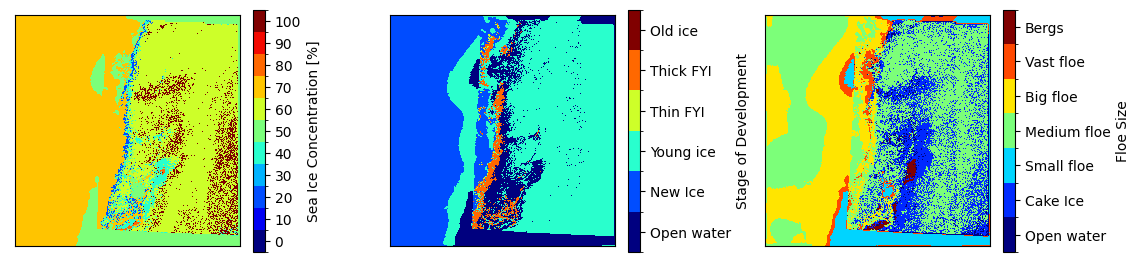

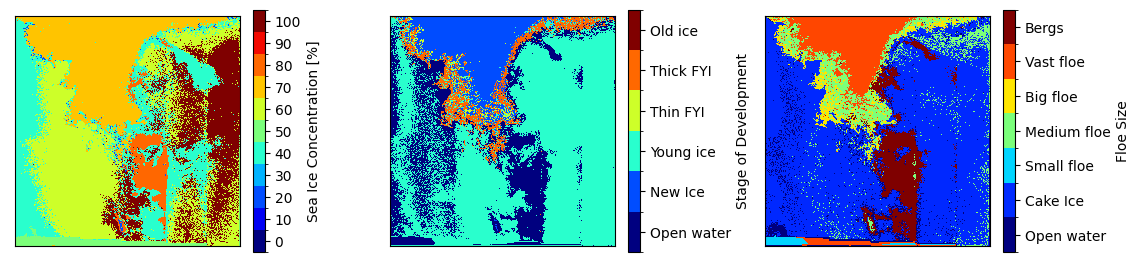

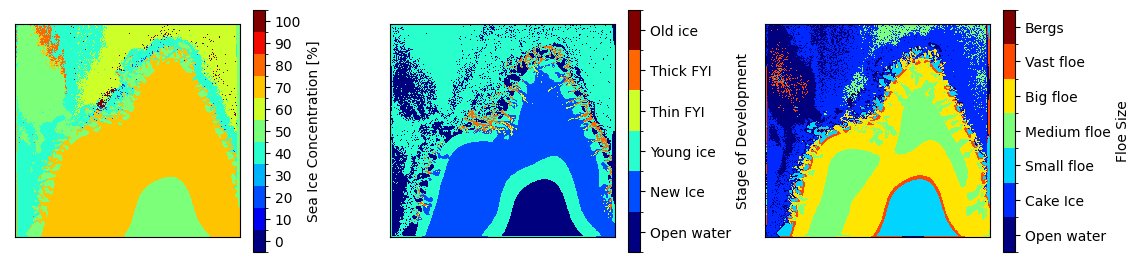


Final batch loss: 5.932
Epoch 0 score:
SIC r2_metric: -178.198%
SOD f1_metric: 29.526%
FLOE f1_metric: 21.453%
Combined score: -55.178%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

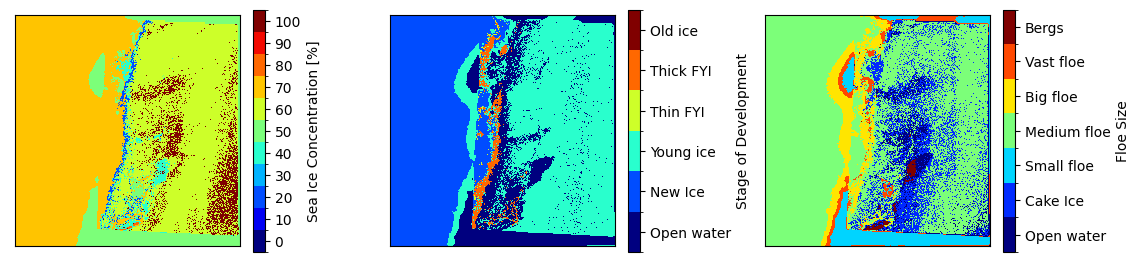

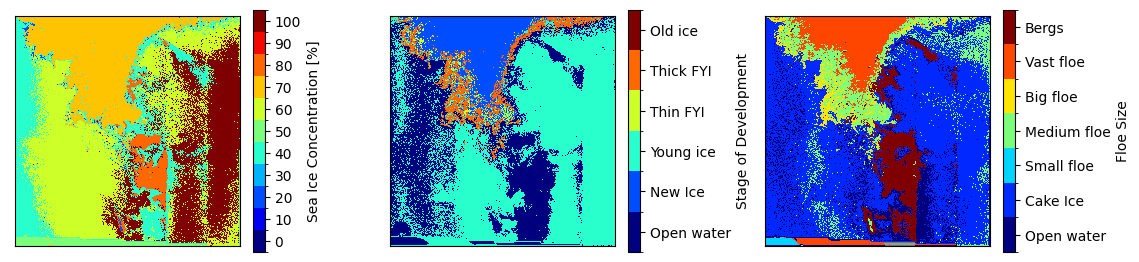

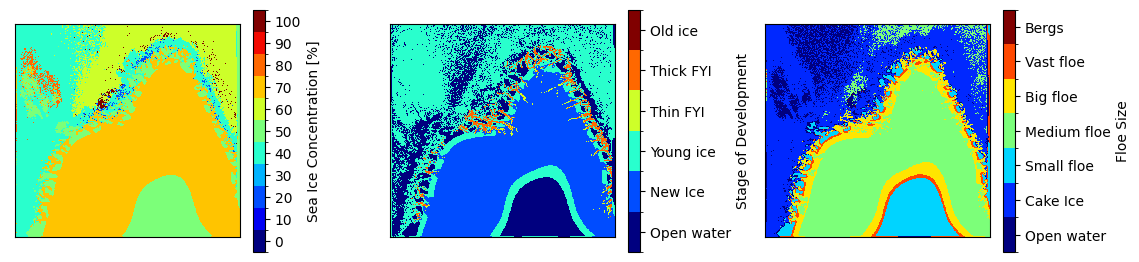


Final batch loss: 6.457
Epoch 1 score:
SIC r2_metric: -195.755%
SOD f1_metric: 35.314%
FLOE f1_metric: 24.787%
Combined score: -59.219%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

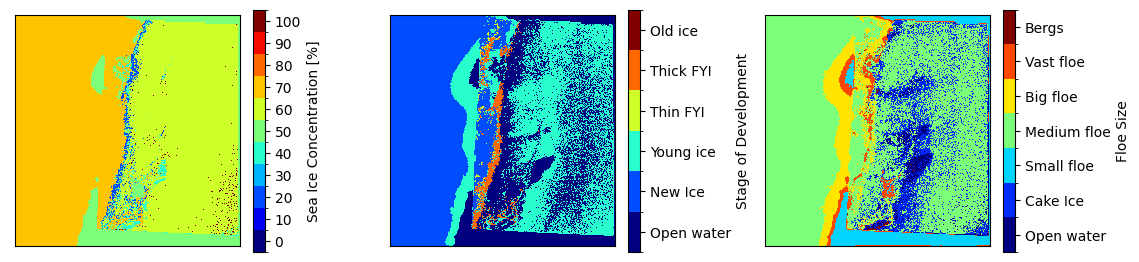

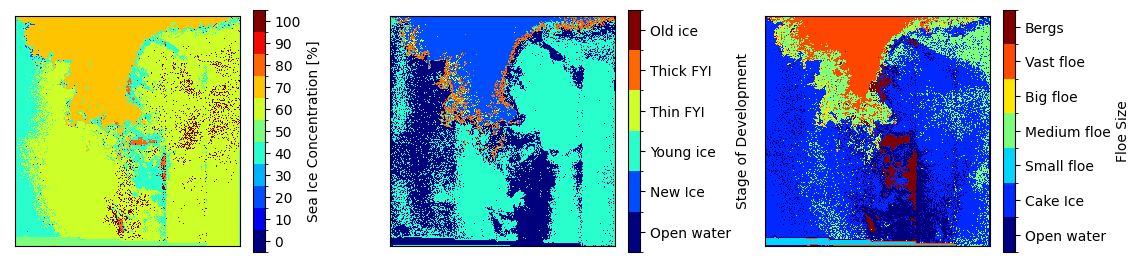

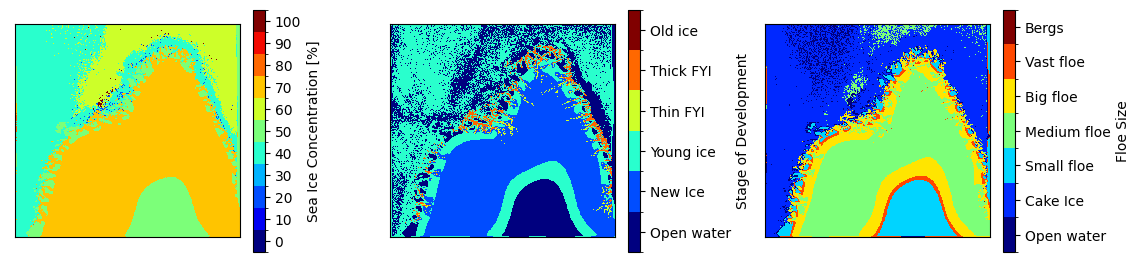


Final batch loss: 6.159
Epoch 2 score:
SIC r2_metric: -120.326%
SOD f1_metric: 44.946%
FLOE f1_metric: 22.923%
Combined score: -25.567%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

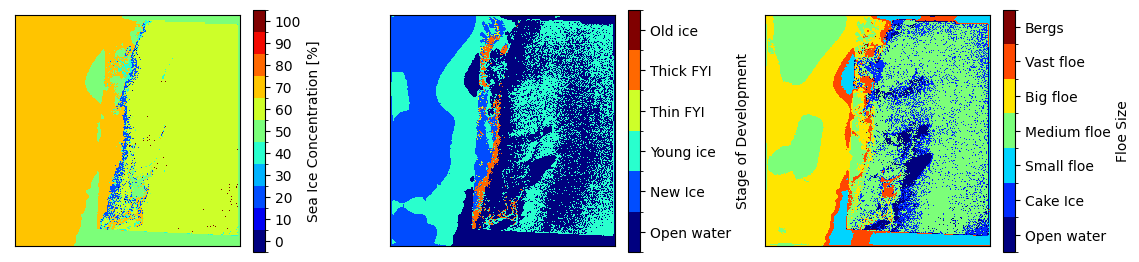

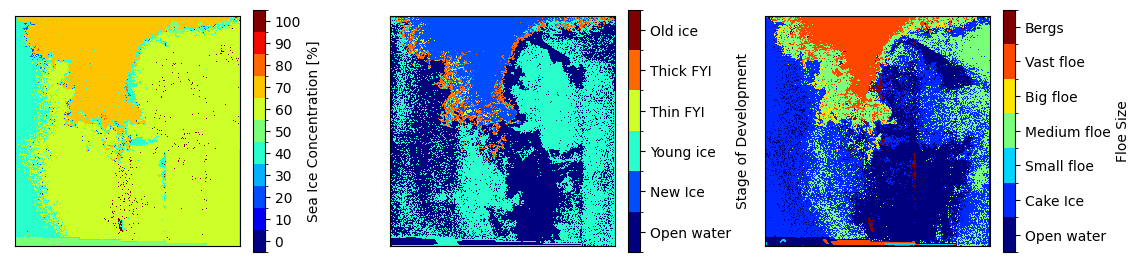

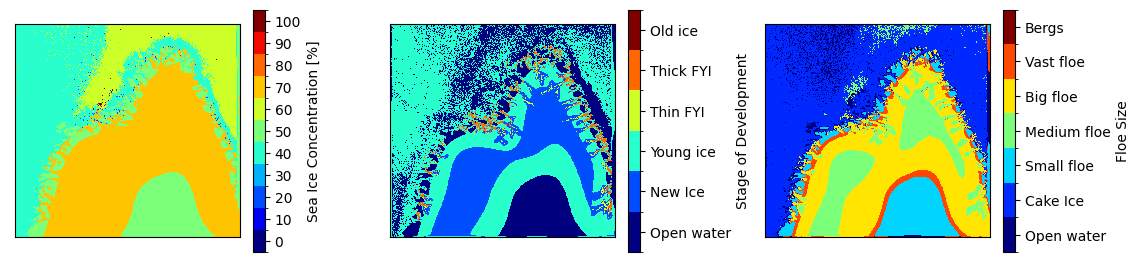


Final batch loss: 5.710
Epoch 3 score:
SIC r2_metric: -113.744%
SOD f1_metric: 53.858%
FLOE f1_metric: 34.208%
Combined score: -17.113%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

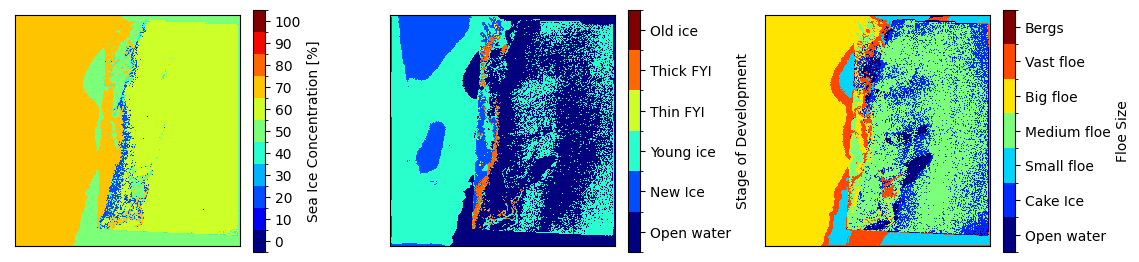

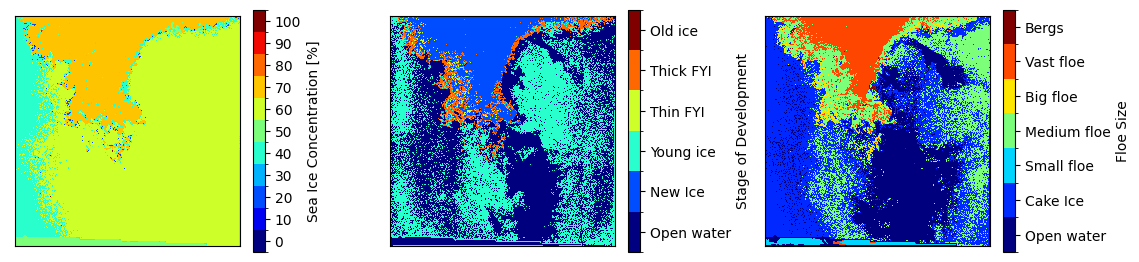

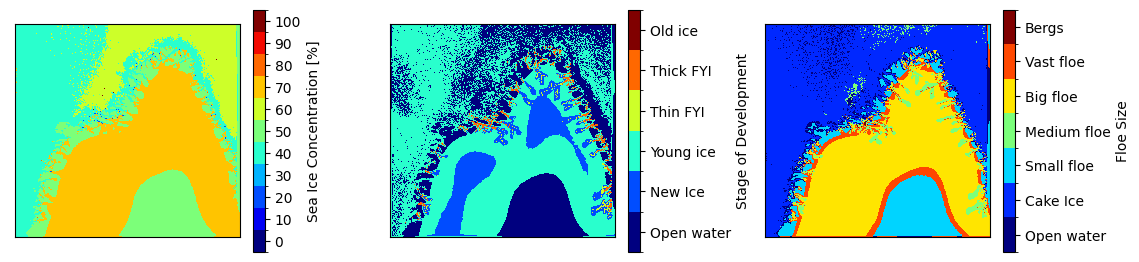


Final batch loss: 6.083
Epoch 4 score:
SIC r2_metric: -112.621%
SOD f1_metric: 56.682%
FLOE f1_metric: 29.488%
Combined score: -16.478%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

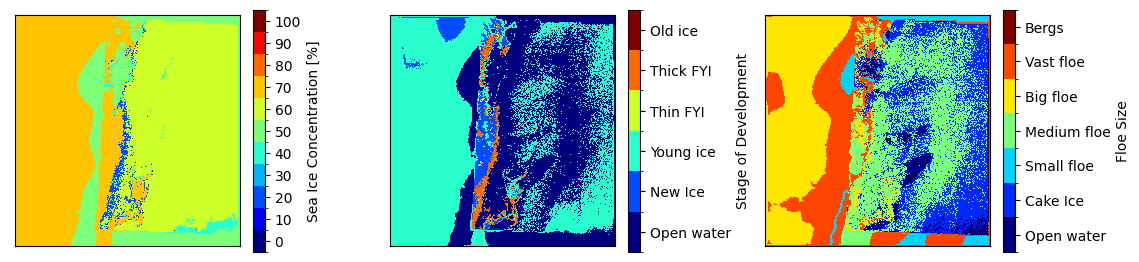

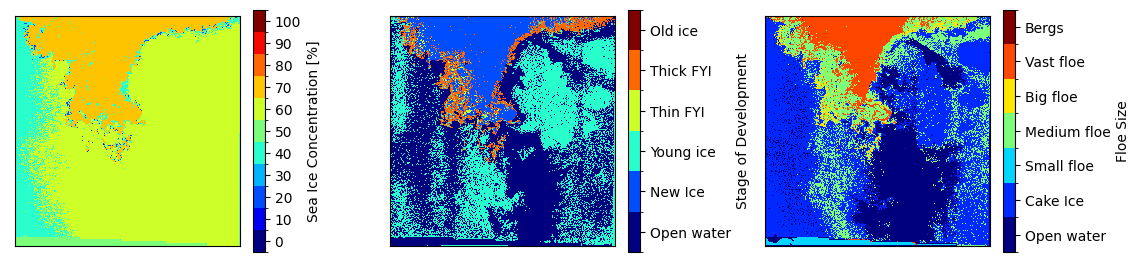

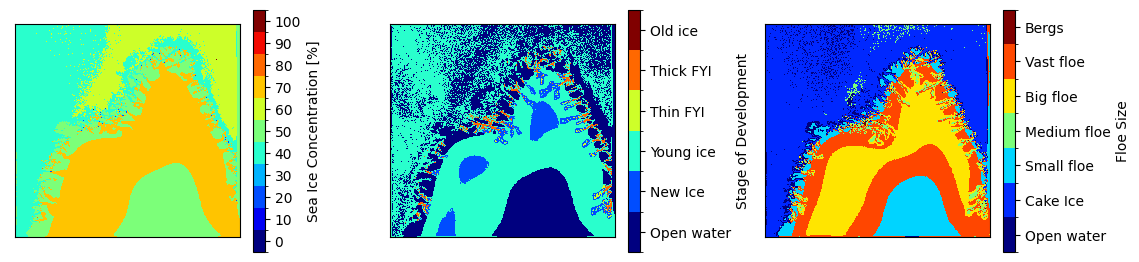


Final batch loss: 5.898
Epoch 5 score:
SIC r2_metric: -111.423%
SOD f1_metric: 58.242%
FLOE f1_metric: 29.95%
Combined score: -15.282%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

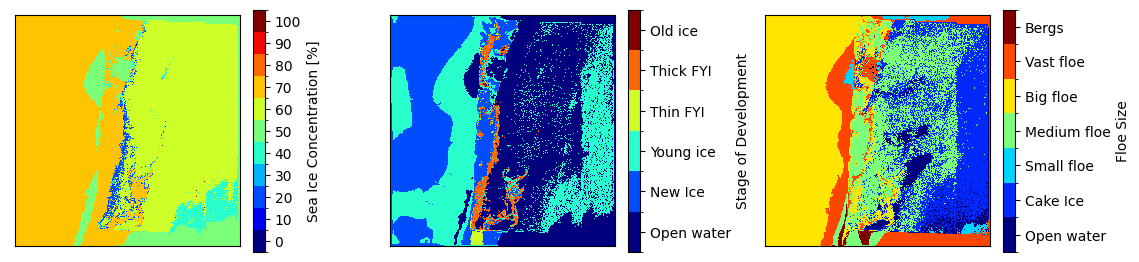

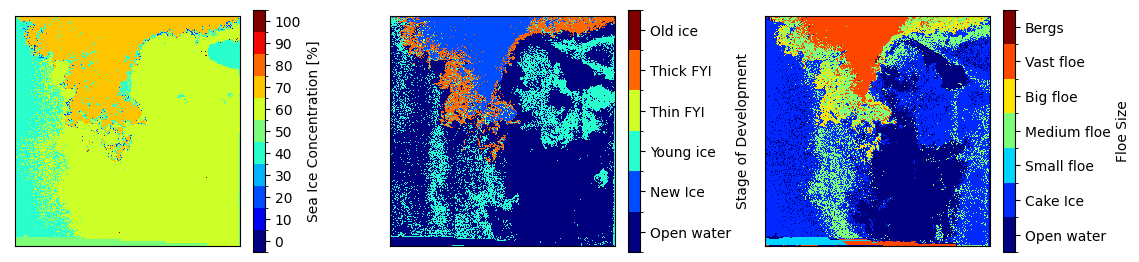

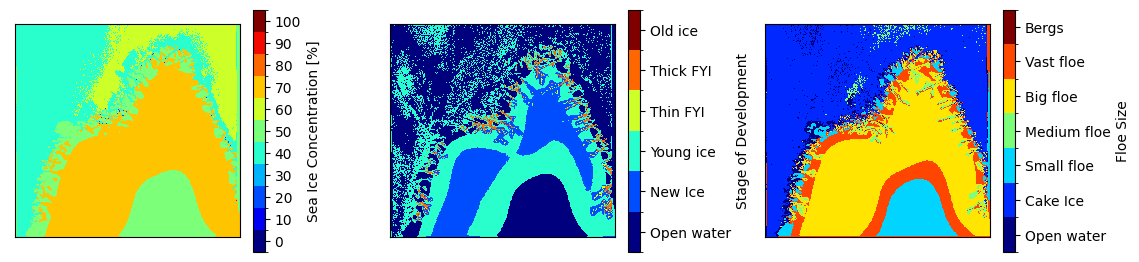


Final batch loss: 5.717
Epoch 6 score:
SIC r2_metric: -104.397%
SOD f1_metric: 69.789%
FLOE f1_metric: 34.169%
Combined score: -7.009%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

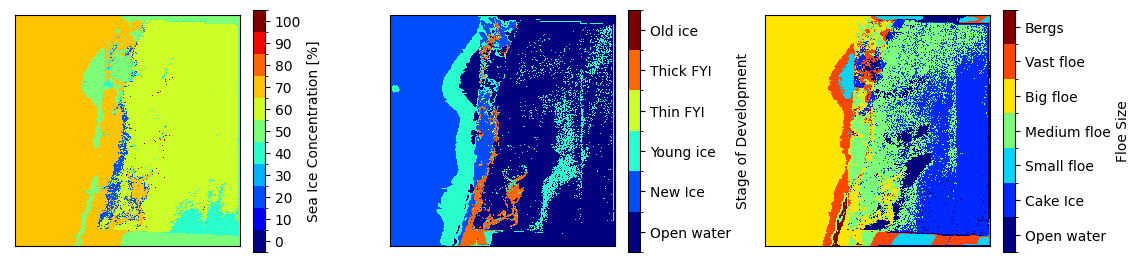

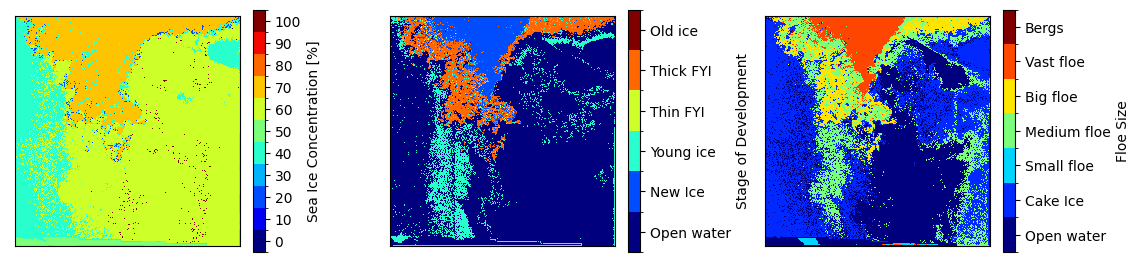

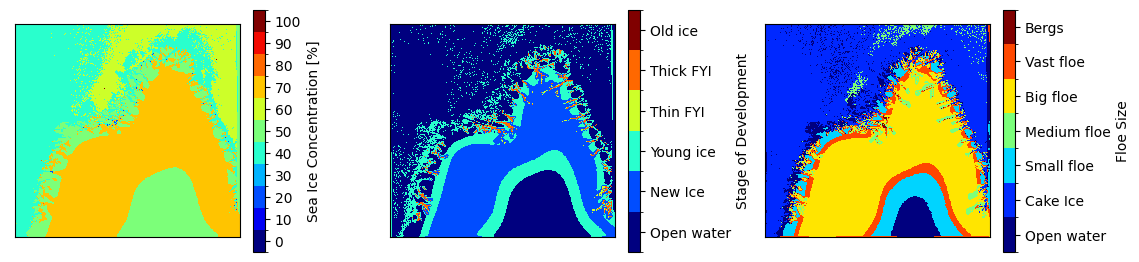


Final batch loss: 5.720
Epoch 7 score:
SIC r2_metric: -104.889%
SOD f1_metric: 76.966%
FLOE f1_metric: 36.543%
Combined score: -3.861%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

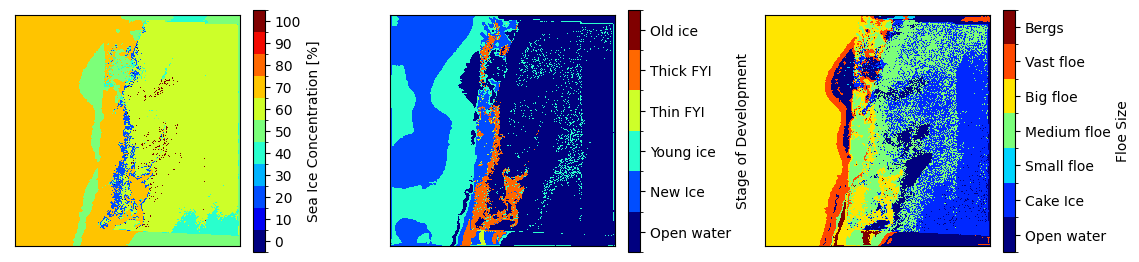

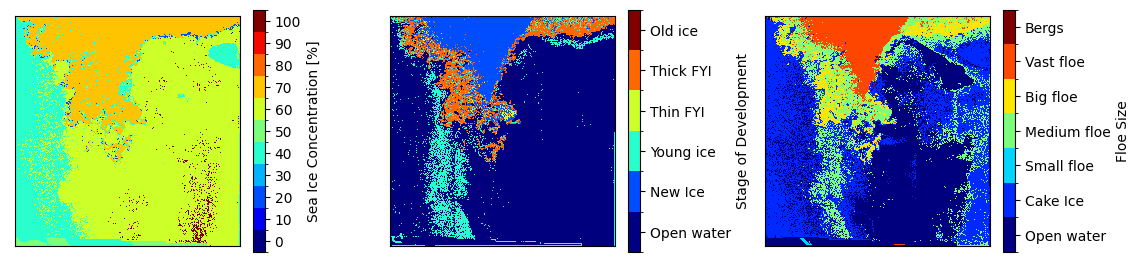

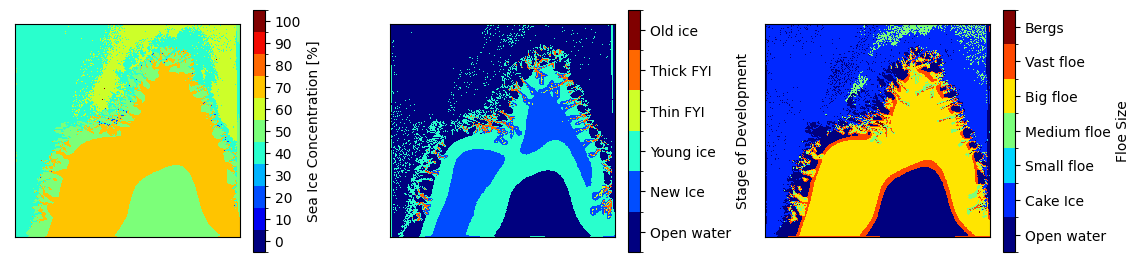


Final batch loss: 5.627
Epoch 8 score:
SIC r2_metric: -106.466%
SOD f1_metric: 80.382%
FLOE f1_metric: 39.971%
Combined score: -2.439%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

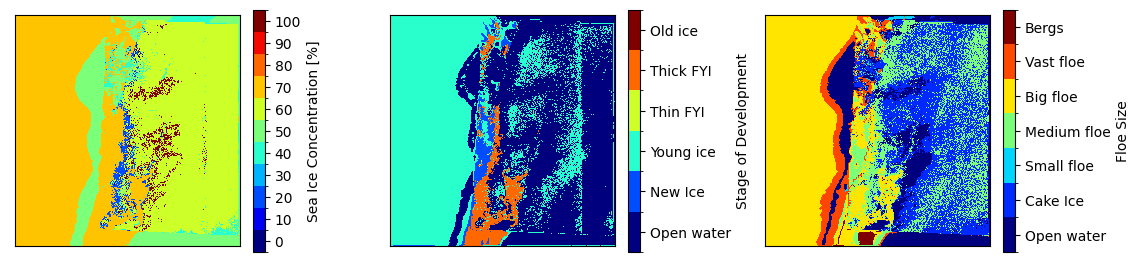

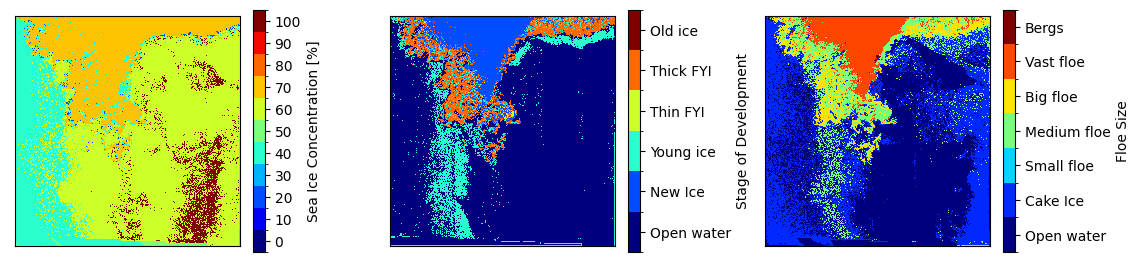

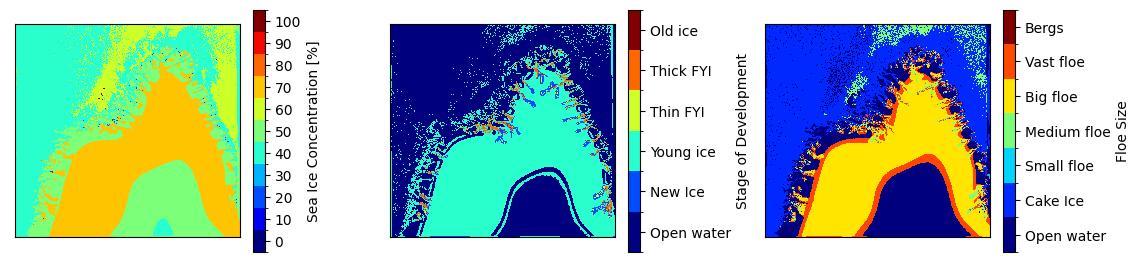


Final batch loss: 5.467
Epoch 9 score:
SIC r2_metric: -126.072%
SOD f1_metric: 78.795%
FLOE f1_metric: 45.893%
Combined score: -9.732%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

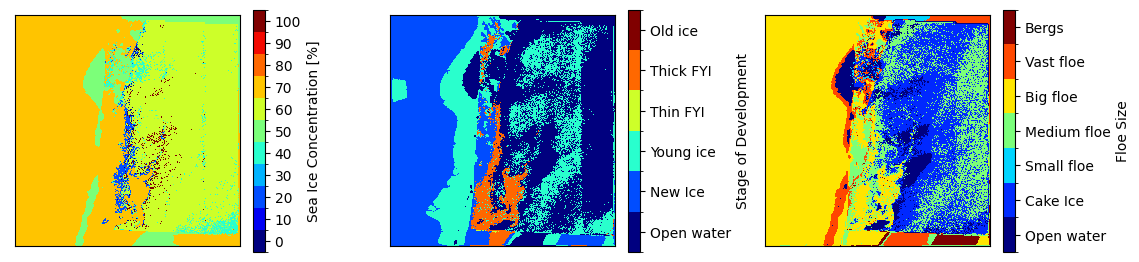

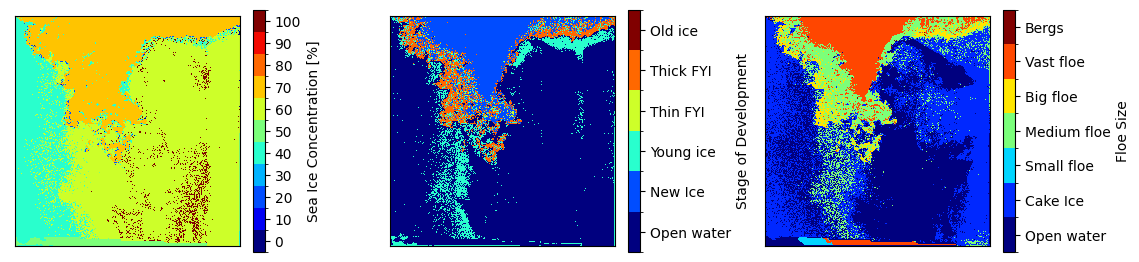

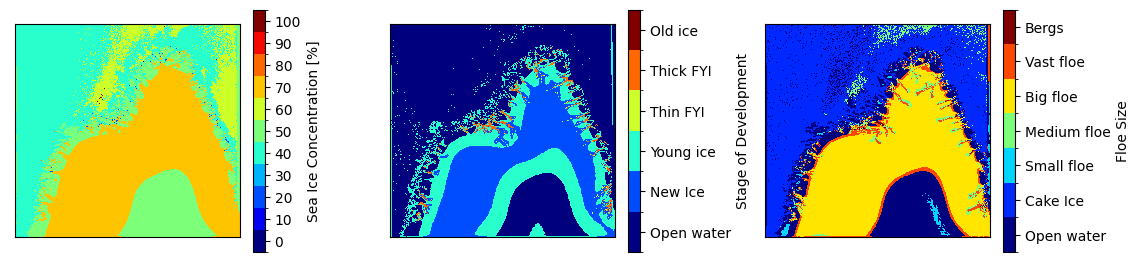


Final batch loss: 5.638
Epoch 0 score:
SIC r2_metric: -108.121%
SOD f1_metric: 79.388%
FLOE f1_metric: 41.301%
Combined score: -3.233%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

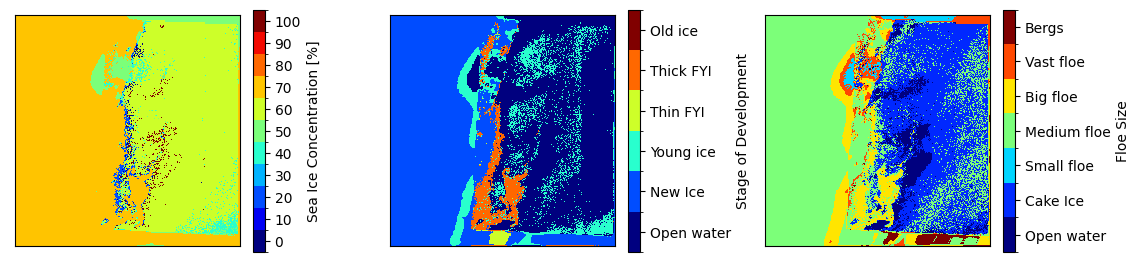

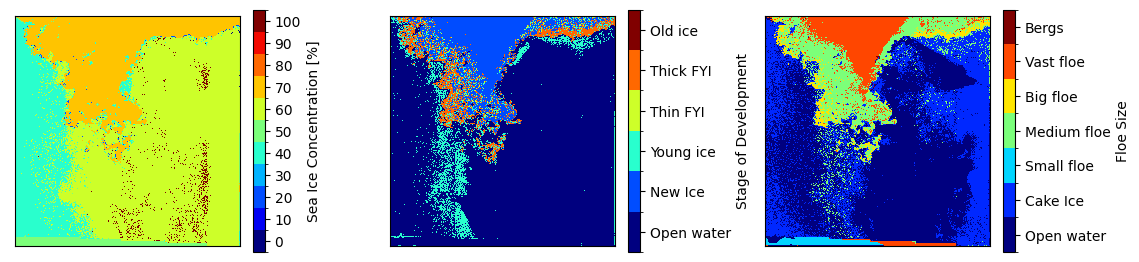

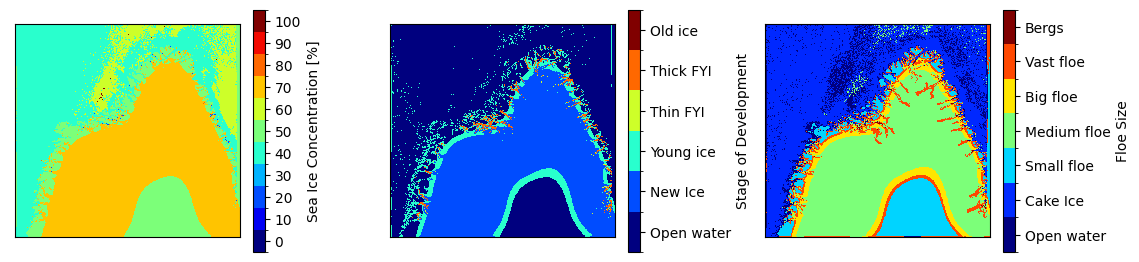


Final batch loss: 5.869
Epoch 1 score:
SIC r2_metric: -104.256%
SOD f1_metric: 80.984%
FLOE f1_metric: 50.322%
Combined score: 0.756%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

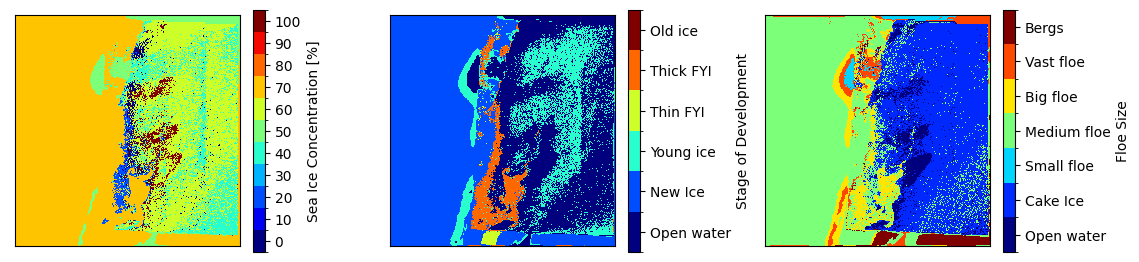

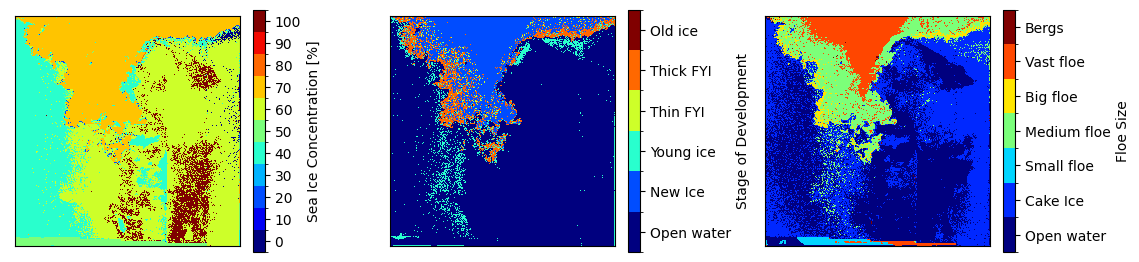

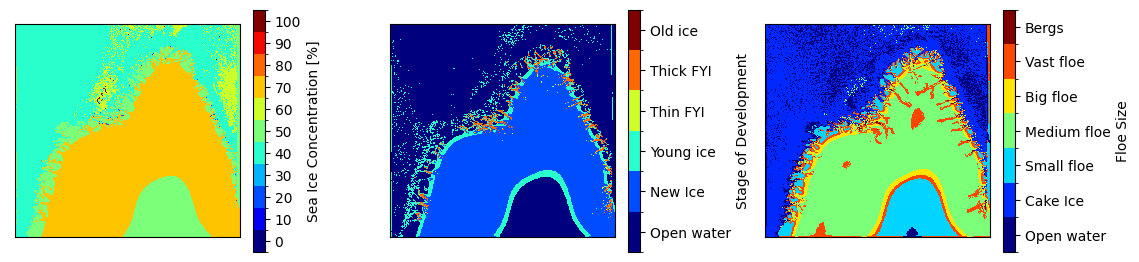


Final batch loss: 6.129
Epoch 2 score:
SIC r2_metric: -109.3%
SOD f1_metric: 79.284%
FLOE f1_metric: 48.697%
Combined score: -2.267%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

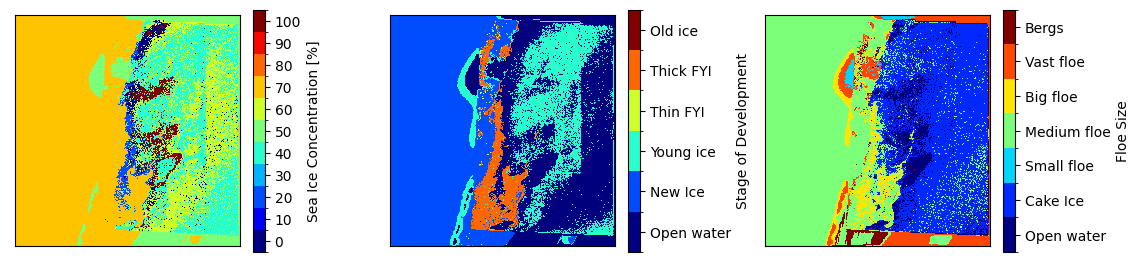

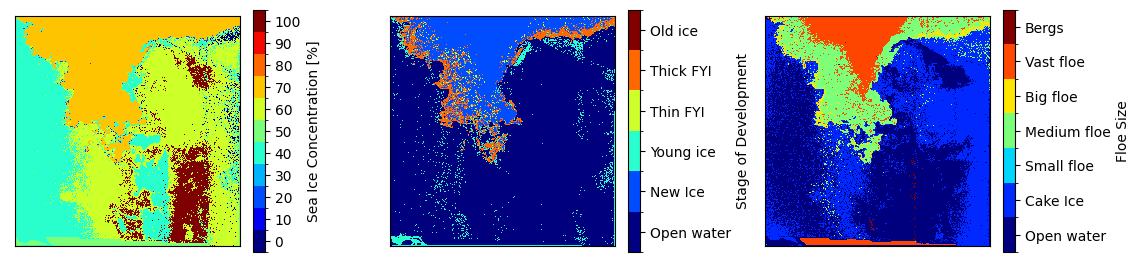

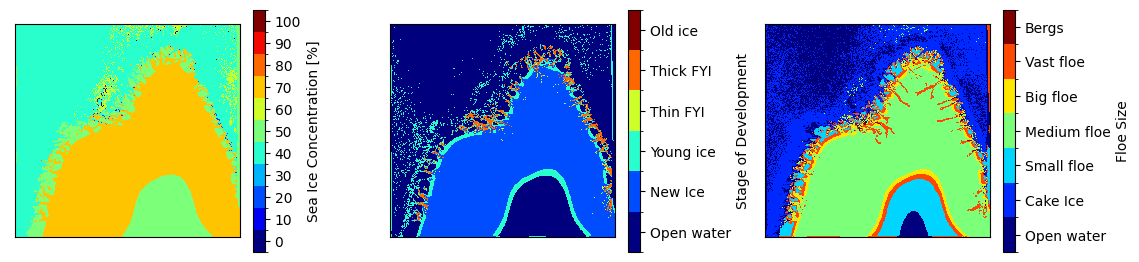


Final batch loss: 5.604
Epoch 3 score:
SIC r2_metric: -96.825%
SOD f1_metric: 79.5%
FLOE f1_metric: 54.451%
Combined score: 3.96%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

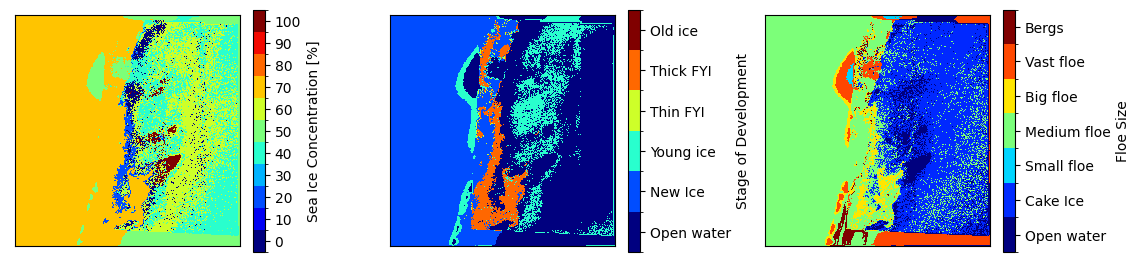

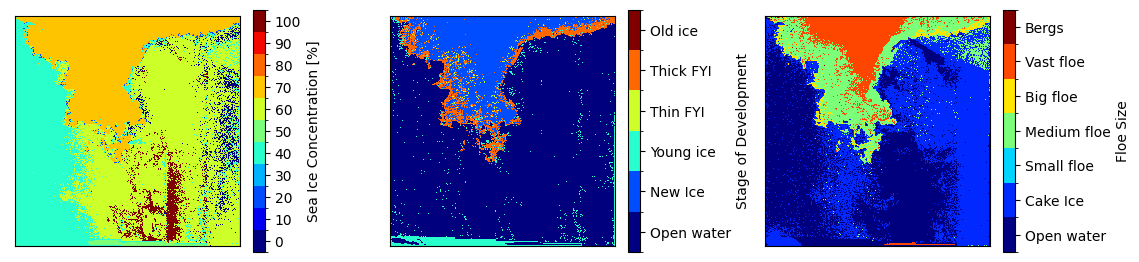

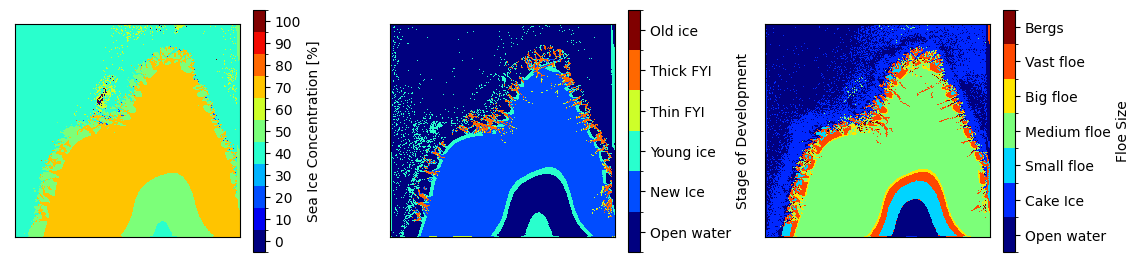


Final batch loss: 5.551
Epoch 4 score:
SIC r2_metric: -81.622%
SOD f1_metric: 81.914%
FLOE f1_metric: 56.203%
Combined score: 11.357%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

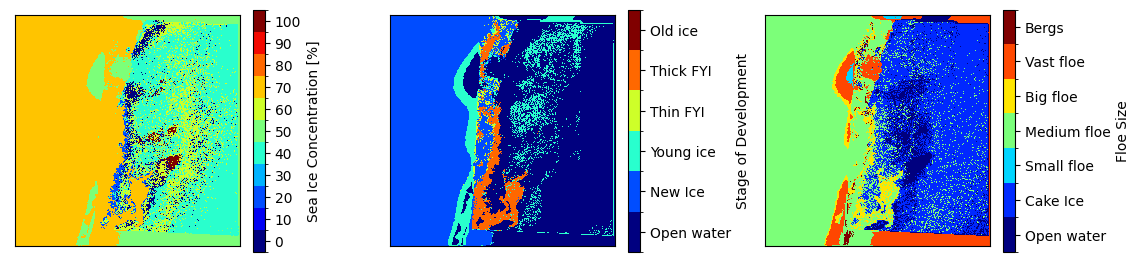

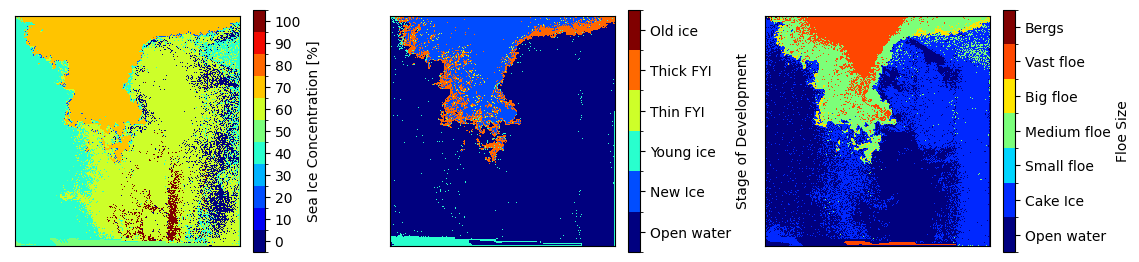

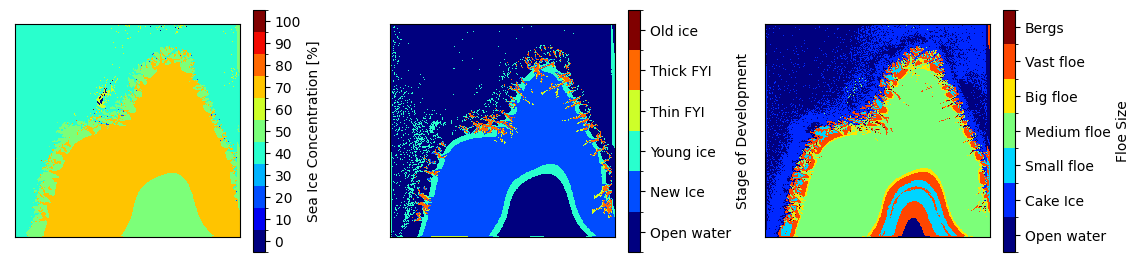


Final batch loss: 5.787
Epoch 5 score:
SIC r2_metric: -60.279%
SOD f1_metric: 82.41%
FLOE f1_metric: 56.983%
Combined score: 20.249%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

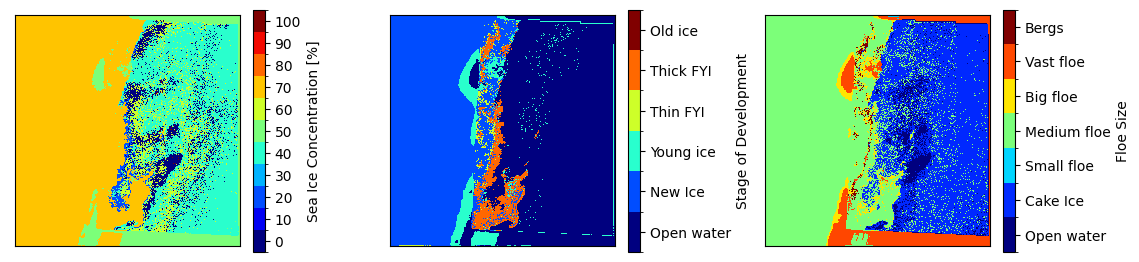

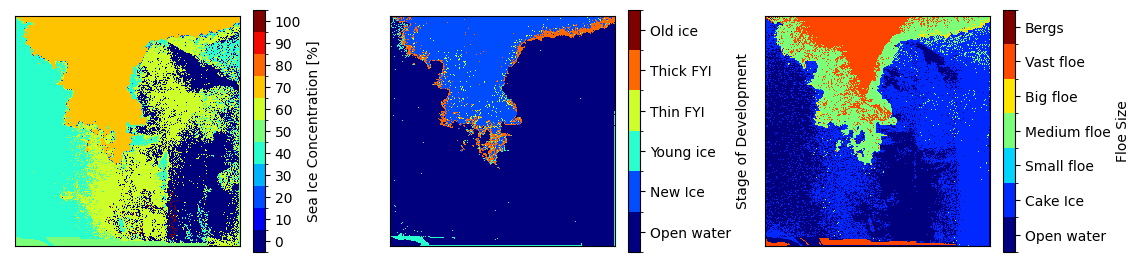

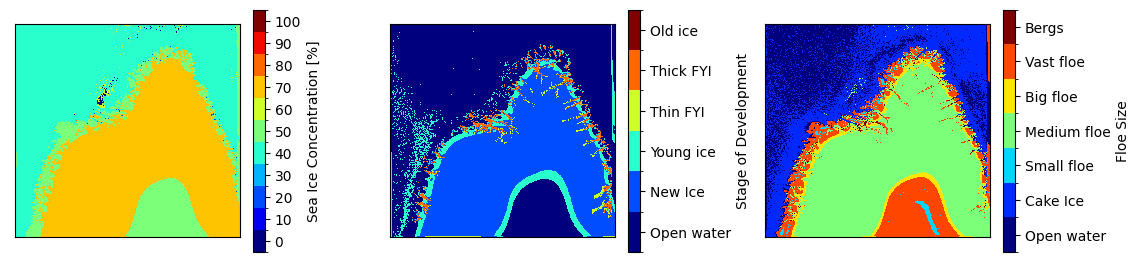


Final batch loss: 5.570
Epoch 6 score:
SIC r2_metric: -29.916%
SOD f1_metric: 83.794%
FLOE f1_metric: 49.841%
Combined score: 31.519%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

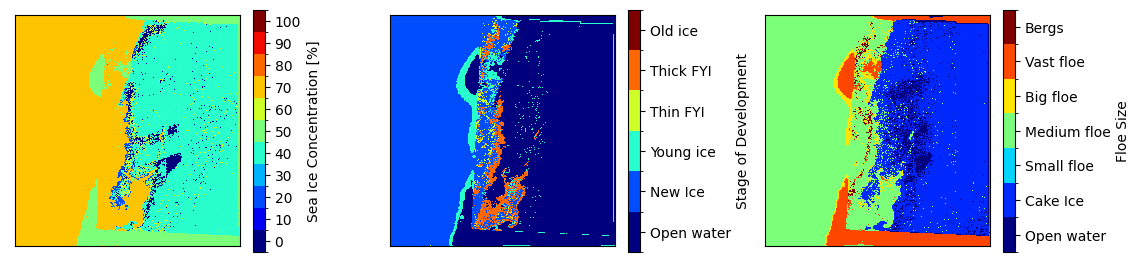

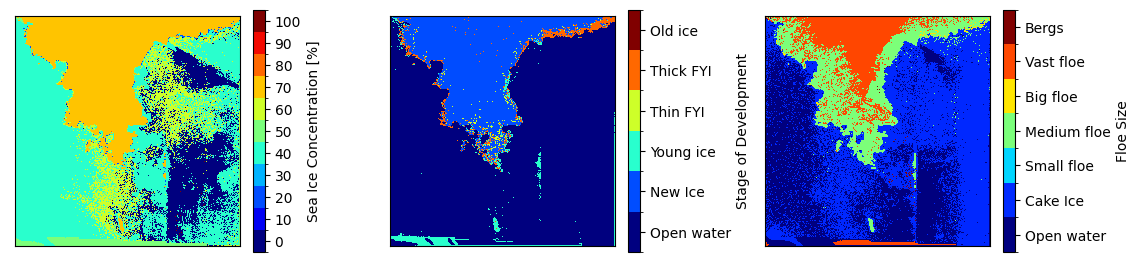

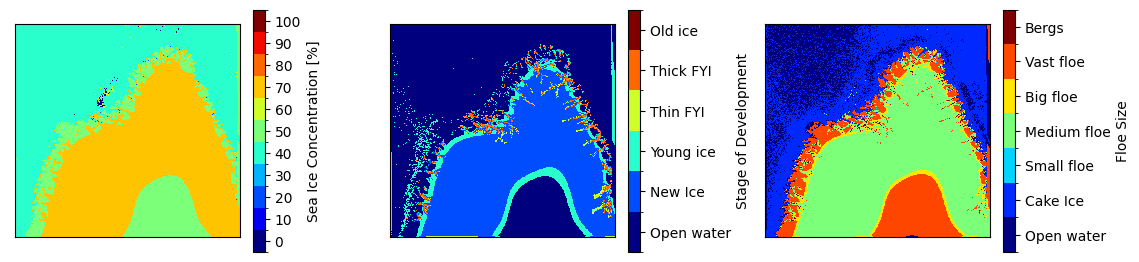


Final batch loss: 5.390
Epoch 7 score:
SIC r2_metric: -19.659%
SOD f1_metric: 83.747%
FLOE f1_metric: 45.853%
Combined score: 34.806%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

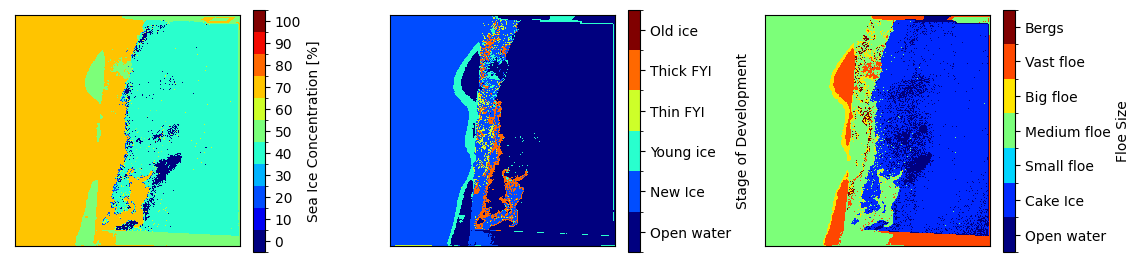

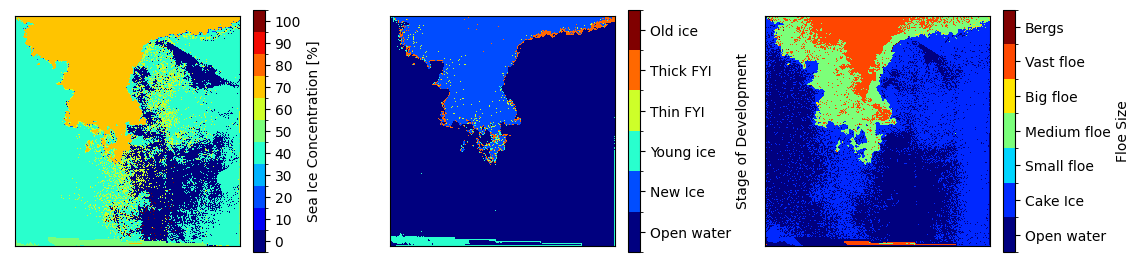

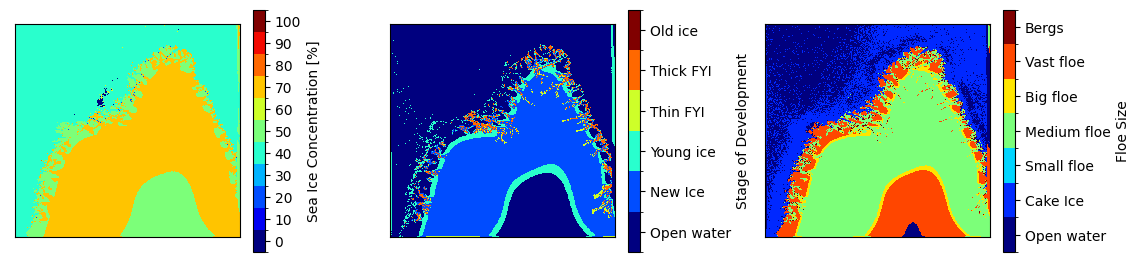


Final batch loss: 5.364
Epoch 8 score:
SIC r2_metric: -13.33%
SOD f1_metric: 82.957%
FLOE f1_metric: 52.212%
Combined score: 38.293%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

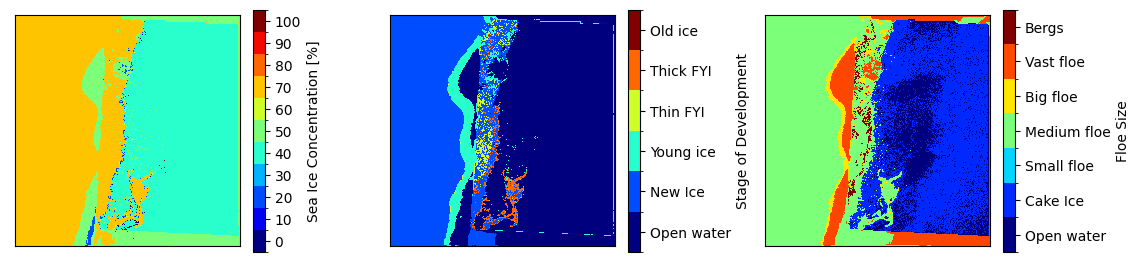

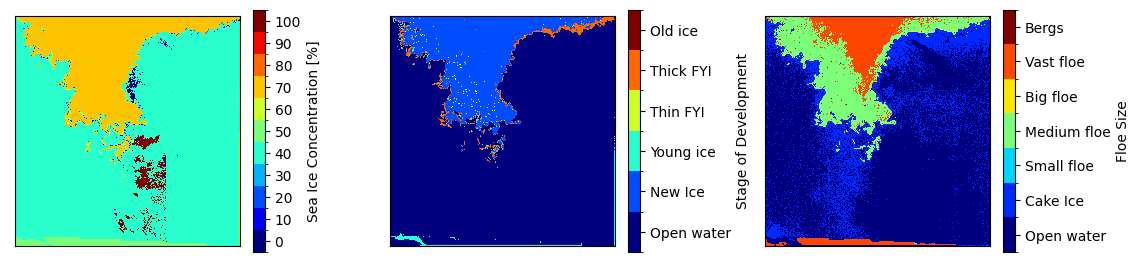

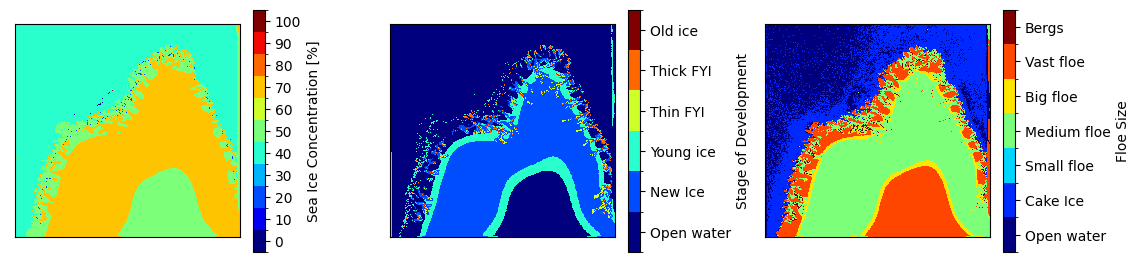


Final batch loss: 5.257
Epoch 9 score:
SIC r2_metric: -25.278%
SOD f1_metric: 81.617%
FLOE f1_metric: 66.171%
Combined score: 35.77%


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

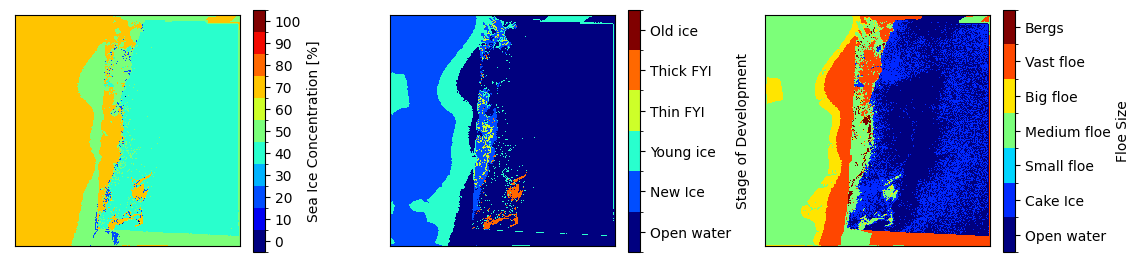

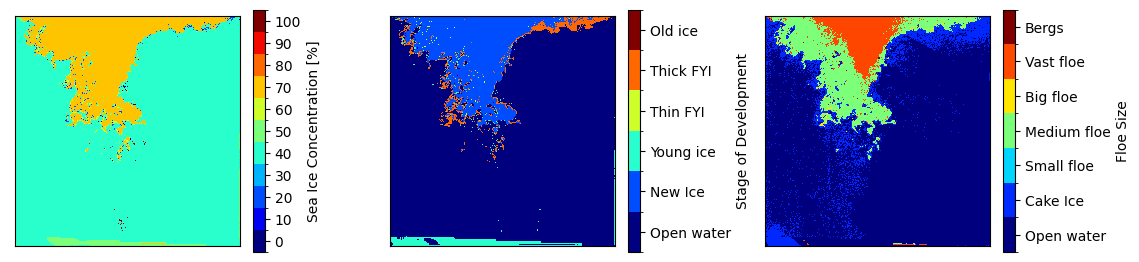

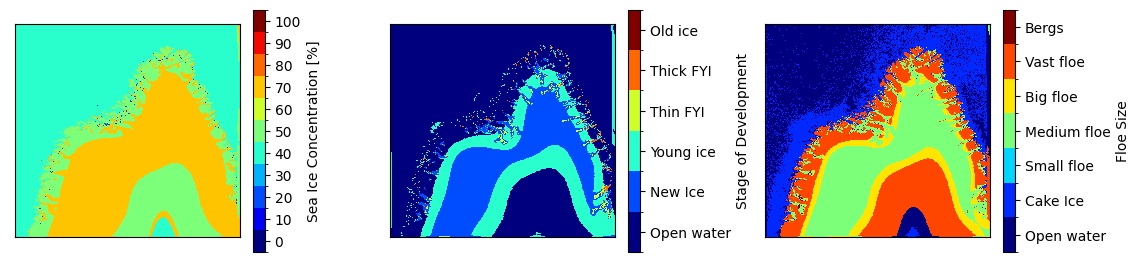


Final batch loss: 5.596
Epoch 0 score:
SIC r2_metric: -19.9%
SOD f1_metric: 80.535%
FLOE f1_metric: 75.413%
Combined score: 39.337%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

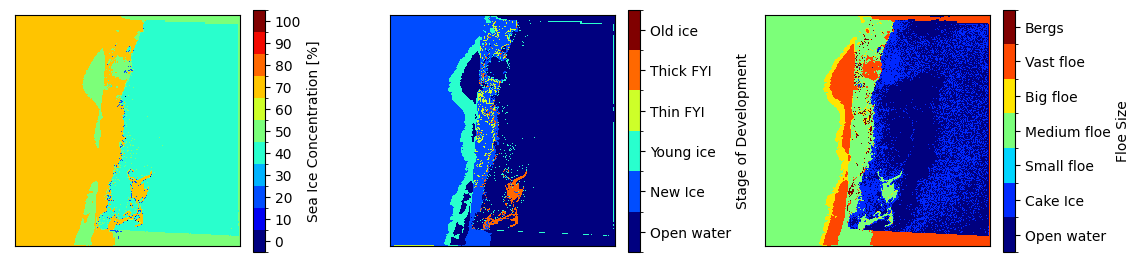

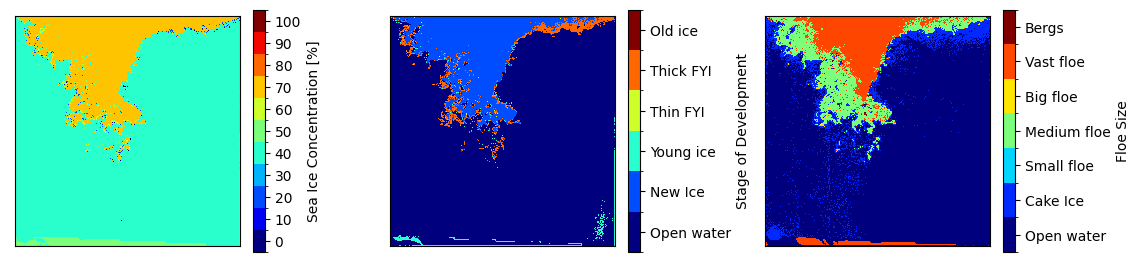

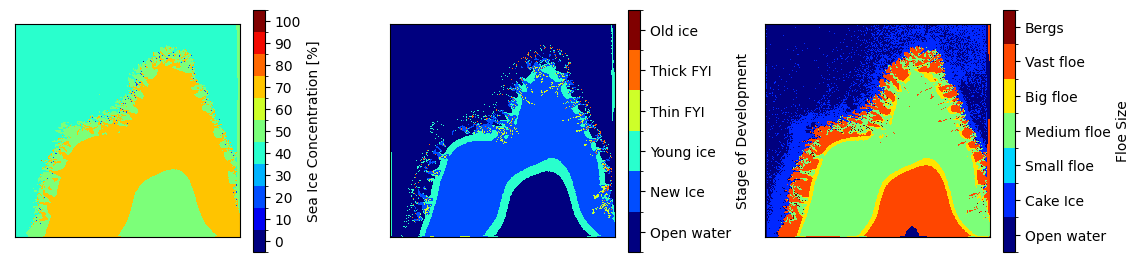


Final batch loss: 5.848
Epoch 1 score:
SIC r2_metric: -18.92%
SOD f1_metric: 81.314%
FLOE f1_metric: 78.025%
Combined score: 40.563%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

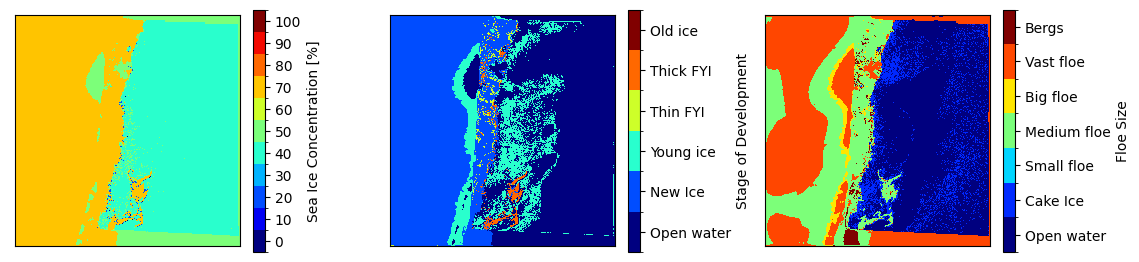

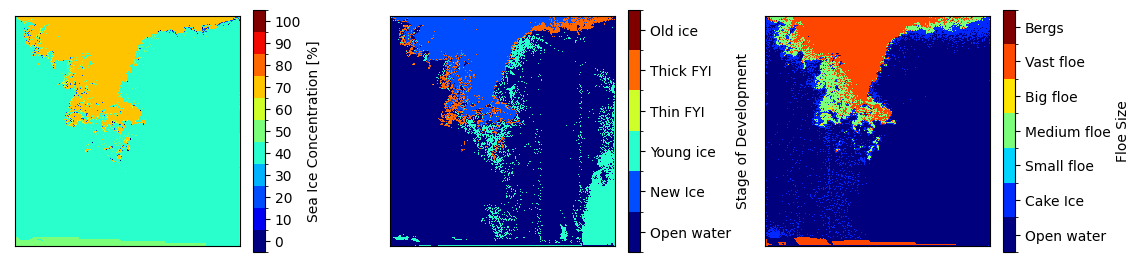

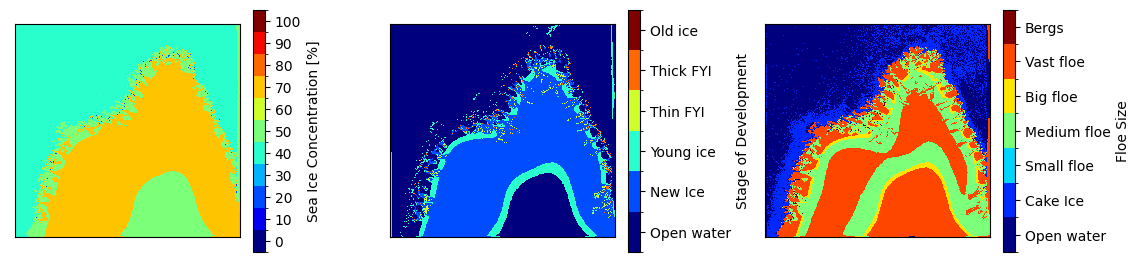


Final batch loss: 6.209
Epoch 2 score:
SIC r2_metric: -19.351%
SOD f1_metric: 78.898%
FLOE f1_metric: 81.052%
Combined score: 40.029%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

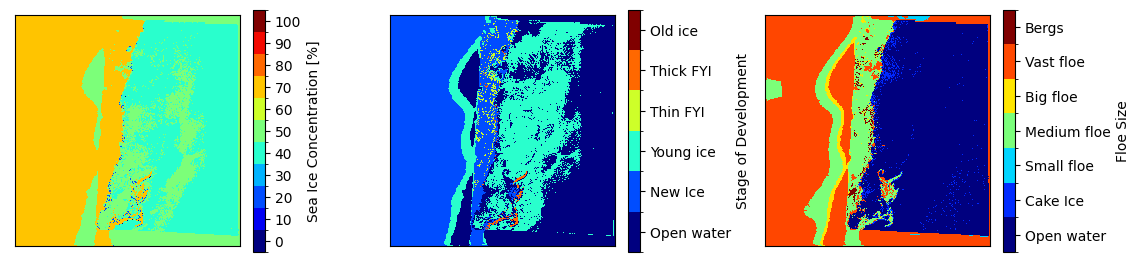

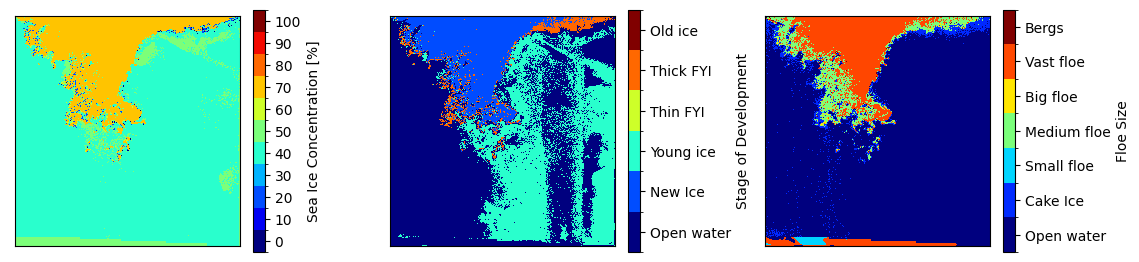

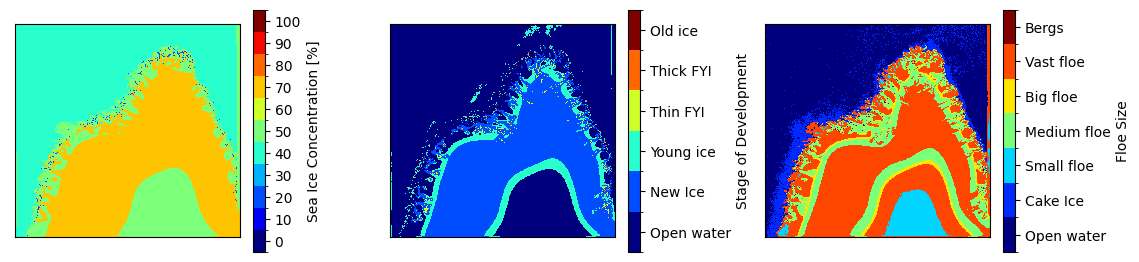


Final batch loss: 5.995
Epoch 3 score:
SIC r2_metric: -23.141%
SOD f1_metric: 68.59%
FLOE f1_metric: 84.097%
Combined score: 34.999%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

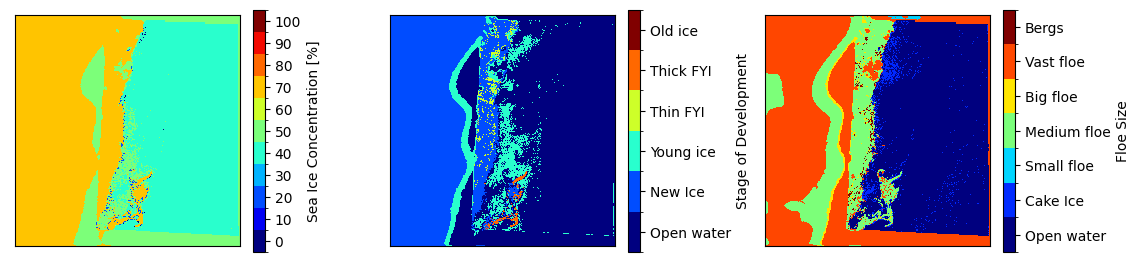

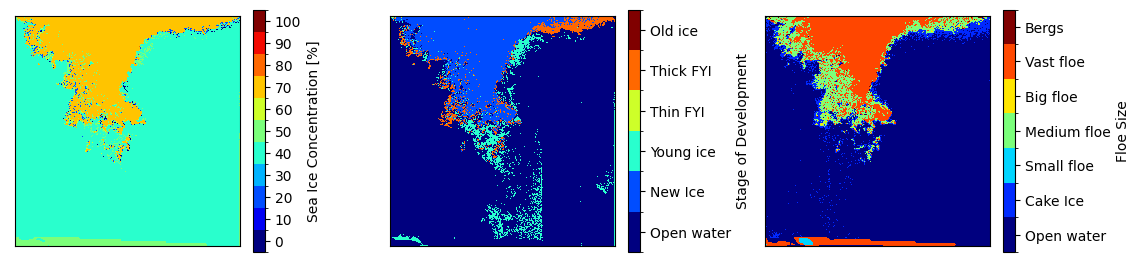

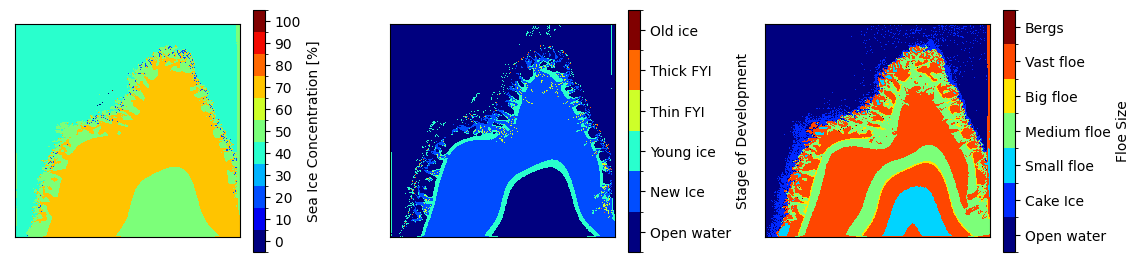


Final batch loss: 5.491
Epoch 4 score:
SIC r2_metric: -19.487%
SOD f1_metric: 80.602%
FLOE f1_metric: 84.714%
Combined score: 41.389%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

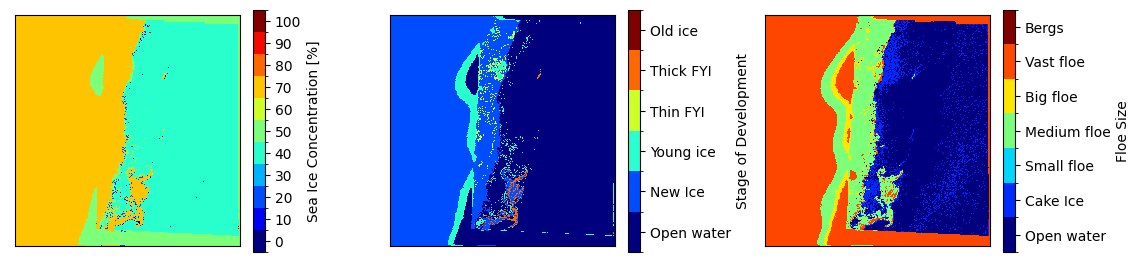

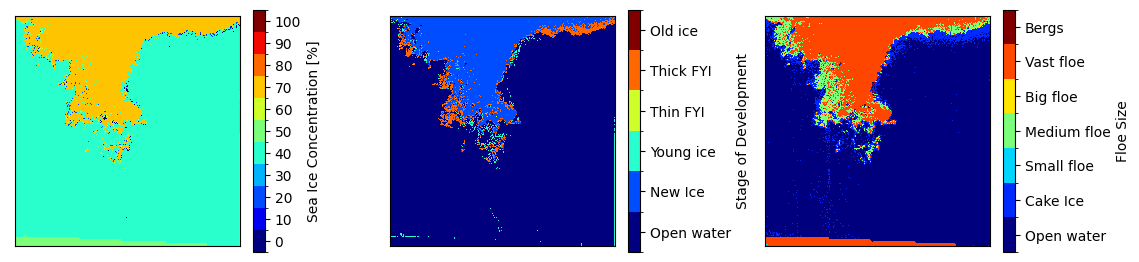

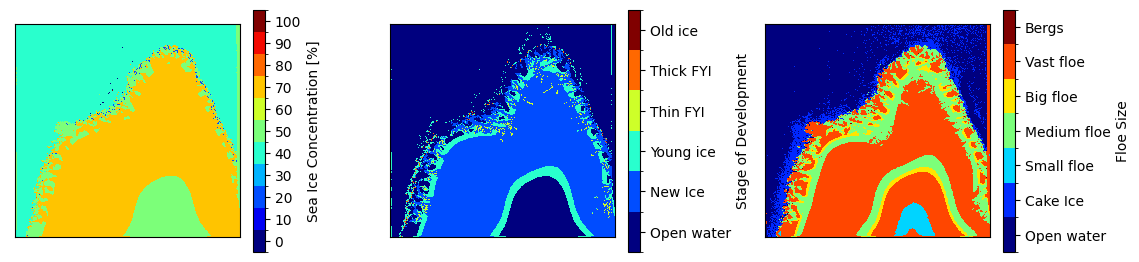


Final batch loss: 5.466
Epoch 5 score:
SIC r2_metric: -19.601%
SOD f1_metric: 80.887%
FLOE f1_metric: 83.415%
Combined score: 41.197%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

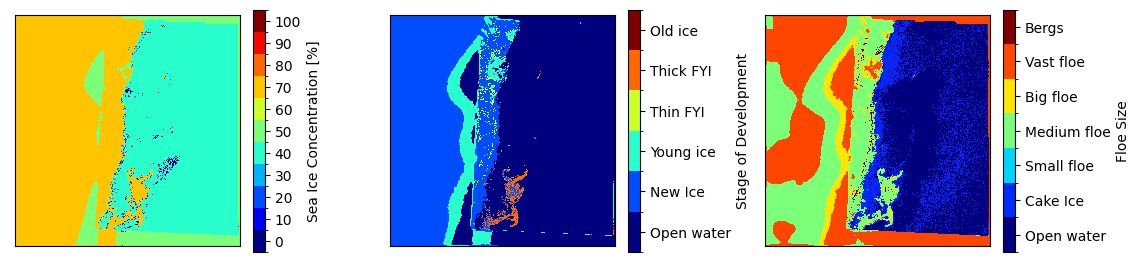

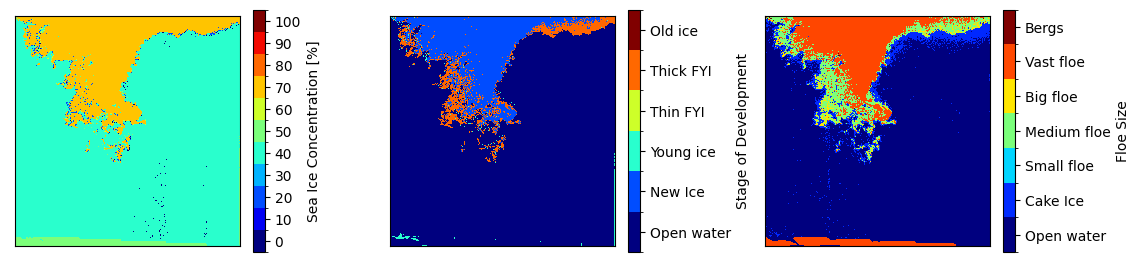

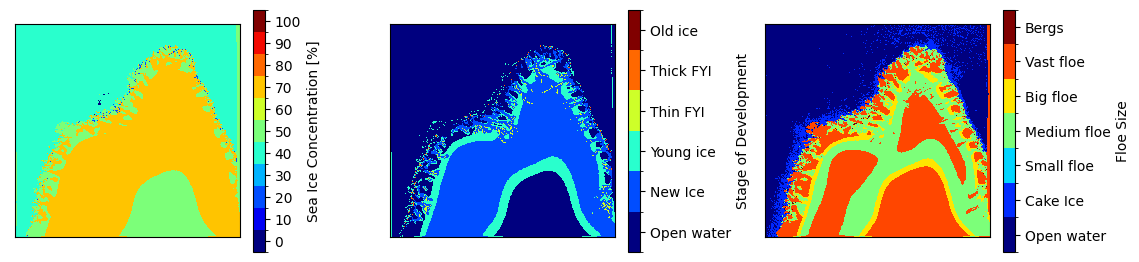


Final batch loss: 5.382
Epoch 6 score:
SIC r2_metric: -19.513%
SOD f1_metric: 81.204%
FLOE f1_metric: 83.687%
Combined score: 41.414%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

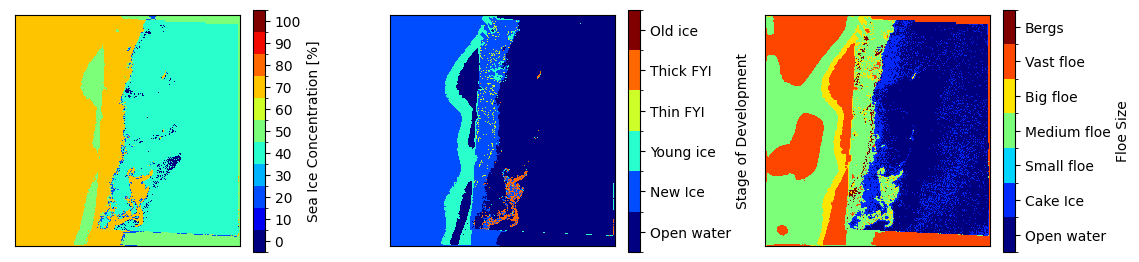

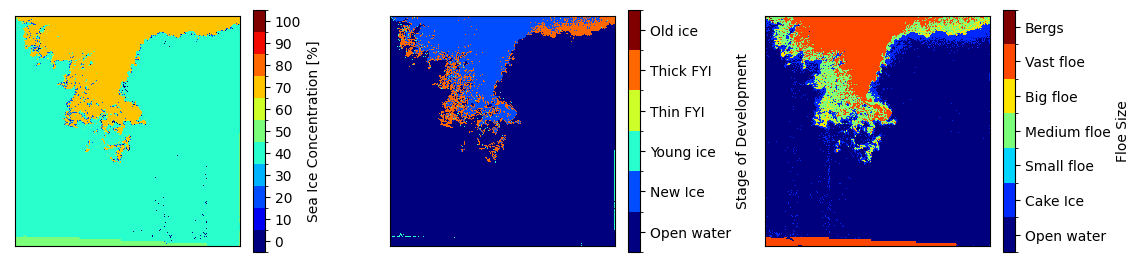

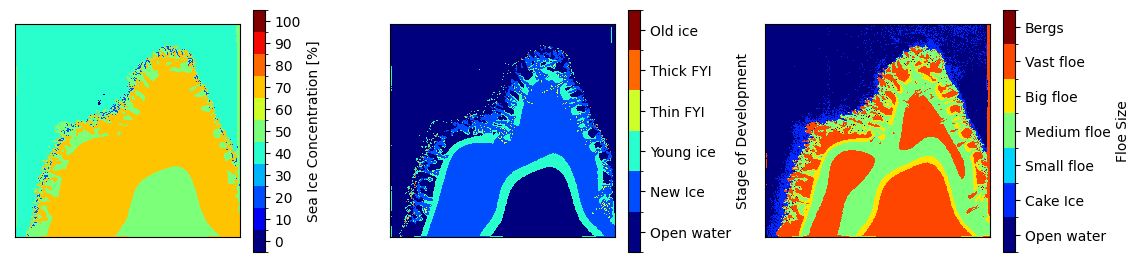


Final batch loss: 5.291
Epoch 7 score:
SIC r2_metric: -19.581%
SOD f1_metric: 81.149%
FLOE f1_metric: 83.745%
Combined score: 41.376%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

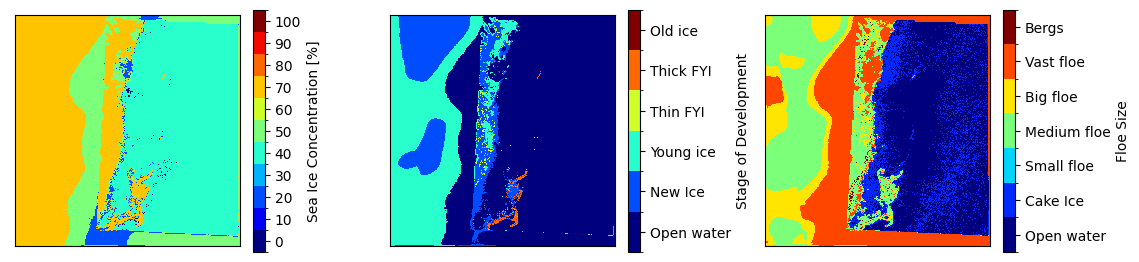

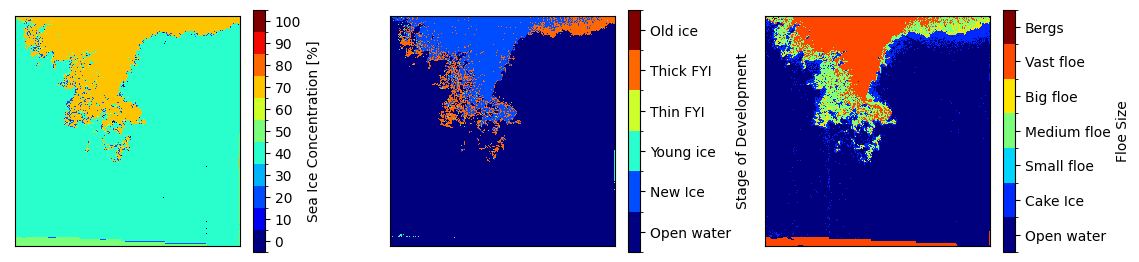

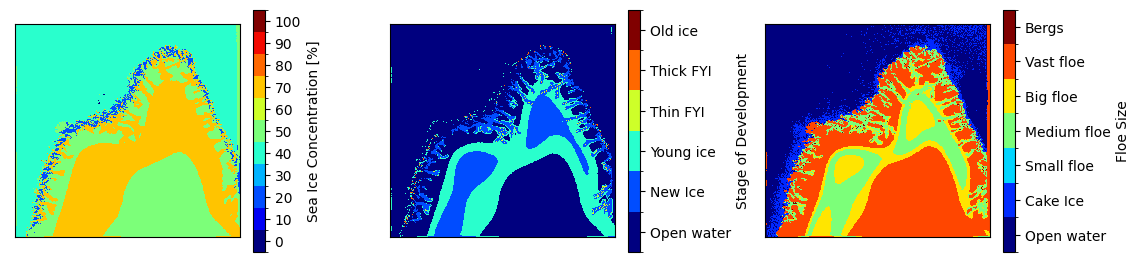


Final batch loss: 5.565
Epoch 8 score:
SIC r2_metric: -20.789%
SOD f1_metric: 80.433%
FLOE f1_metric: 82.677%
Combined score: 40.393%


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

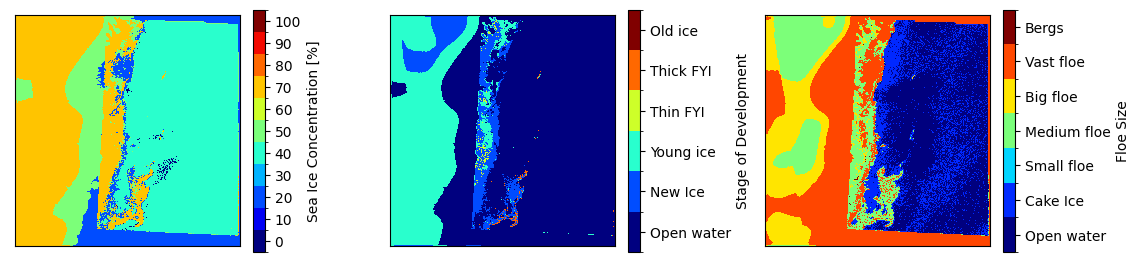

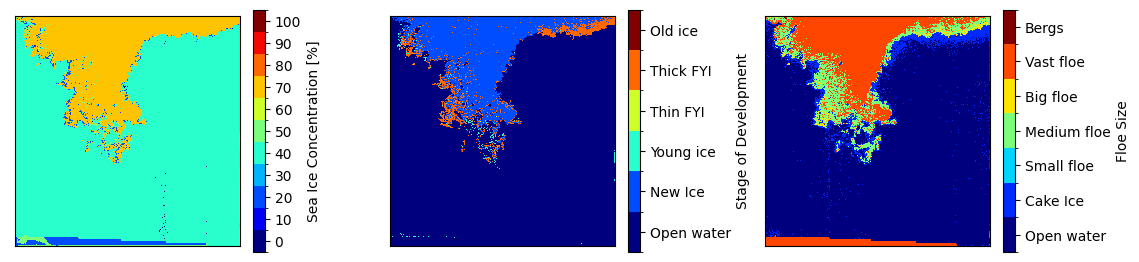

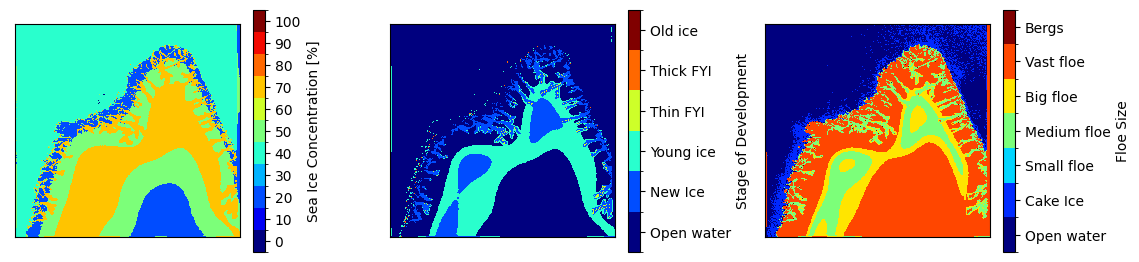


Final batch loss: 5.052
Epoch 9 score:
SIC r2_metric: -21.166%
SOD f1_metric: 80.265%
FLOE f1_metric: 80.794%
Combined score: 39.798%


In [39]:
import matplotlib.pyplot as plt

best_combined_score = 0  # Best weighted model score.



curriculum_dict ={
    'high_quality' : batch_1_dataloader,
    'high_&_moderate_quality_inputs' : batch_2_dataloader,
    'all_inputs' : batch_3_dataloader
}


session_id = 'first_curriculum'

#shorten training while developing
train_options['epoch_len'] = 5
train_options['epochs'] = 10

# - Shorten the val list from 10 samples to 3, with hack, just while developing
dataset_val = AI4ArcticChallengeTestDataset(options=train_options, files=train_options['validate_list'][:3], force_selection= train_options['train_variables'], test=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=None, num_workers=train_options['num_workers_val'], shuffle=False)


for dataset_quality, dataloader in curriculum_dict.items():

    # -- Training Loop -- #
    for epoch in tqdm(iterable=range(train_options['epochs']), position=0):
        gc.collect()  # Collect garbage to free memory.
        loss_sum = torch.tensor([0.])  # To sum the batch losses during the epoch.
        net.train()  # Set network to evaluation mode.




        # Loops though batches in queue.
        for i, (batch_x, batch_y) in enumerate(tqdm(iterable=dataloader, total=train_options['epoch_len'], colour='red', position=0)):

            torch.cuda.empty_cache()  # Empties the GPU cache freeing up memory.
            loss_batch = 0  # Reset from previous batch.

            # - Transfer to device.
            batch_x = batch_x.to(device, non_blocking=True)

            # - Mixed precision training. (Saving memory)
            with torch.cuda.amp.autocast():
                # - Forward pass.
                output = net(batch_x)

                # - Calculate loss.
                for chart in train_options['charts']:
                    loss_batch += loss_functions[chart](input=output[chart], target=batch_y[chart].to(device))

            # - Reset gradients from previous pass.
            optimizer.zero_grad()

            # - Backward pass.
            loss_batch.backward()

            # - Optimizer step
            optimizer.step()

            # - Add batch loss.
            loss_sum += loss_batch.detach().item()

            # - Average loss for displaying
            loss_epoch = torch.true_divide(loss_sum, i + 1).detach().item()
            print(f'\rMean training loss in {dataset_quality}, epoch {epoch} of 10: ' + f'{loss_epoch:.3f}', end='\r')
            del output, batch_x, batch_y # Free memory.
        del loss_sum






        # -- Validation Loop -- #
        loss_batch = loss_batch.detach().item()  # For printing after the validation loop.

        # - Stores the output and the reference pixels to calculate the scores after inference on all the scenes.
        outputs_flat = {chart: np.array([]) for chart in train_options['charts']}
        inf_ys_flat = {chart: np.array([]) for chart in train_options['charts']}

        net.eval()  # Set network to evaluation mode.
        # - Loops though scenes in queue.
        torch.cuda.empty_cache()
        i=0
        for inf_x, inf_y, masks, name in tqdm(iterable=dataloader_val, total=len(train_options['validate_list']), colour='green', position=0):
            gc.collect()
            torch.cuda.empty_cache()

            # - Ensures that no gradients are calculated, which otherwise take up a lot of space on the GPU.
            with torch.no_grad(), torch.cuda.amp.autocast():
                inf_x = inf_x.to(device, non_blocking=True)
                output = net(inf_x)

            # - Final output layer, and storing of non masked pixels.
            for chart in train_options['charts']:
                output[chart] = torch.argmax(output[chart], dim=1).squeeze().cpu().numpy()
                outputs_flat[chart] = np.append(outputs_flat[chart], output[chart][~masks[chart]])
                inf_ys_flat[chart] = np.append(inf_ys_flat[chart], inf_y[chart][~masks[chart]].numpy())

            fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))


            for idx, chart in enumerate(train_options['charts']):
                ax = axs[idx]
                output[chart] = output[chart].astype(int)
                #output[chart][masks] = np.nan
                ax.imshow(output[chart], vmin=0, vmax=train_options['n_classes'][chart] - 2, cmap='jet', interpolation='nearest')
                ax.set_xticks([])
                ax.set_yticks([])
                chart_cbar(ax=ax, n_classes=train_options['n_classes'][chart], chart=chart, cmap='jet')


            plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=-0)
            fig.savefig("inference/ModelOutput_{}_{}_{}.png".format(session_id, idx, i), format='png', dpi=150, bbox_inches="tight")
            plt.show()
            plt.close('all')


            del inf_x, masks, output, fig, axs,
            gc.collect()
            torch.cuda.empty_cache()


            fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

            for idx, chart in enumerate(train_options['charts']):
                ax= axs[idx]
                ground_truth= inf_y[chart].numpy()
                ax.imshow(ground_truth, vmin=0, vmax=train_options['n_classes'][chart] - 2, cmap='jet', interpolation='nearest')
                ax.set_xticks([])
                ax.set_yticks([])
                chart_cbar(ax=ax, n_classes=train_options['n_classes'][chart], chart=chart, cmap='jet')


            plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=-0)
            fig.savefig("inference/Ground_Truth_{}_{}_{}.png".format(session_id, idx, i), format='png', dpi=150, bbox_inches="tight")
            plt.close('all')

            i+=1

            del inf_y, ground_truth
            gc.collect()# Free memory.
            torch.cuda.empty_cache()



        # - Compute the relevant scores.
        combined_score, scores = compute_metrics(true=inf_ys_flat, pred=outputs_flat, charts=train_options['charts'],
                                                 metrics=train_options['chart_metric'])

        print("")
        print(f"Final batch loss: {loss_batch:.3f}")
        print(f"Epoch {epoch} score:")
        for chart in train_options['charts']:
            print(f"{chart} {train_options['chart_metric'][chart]['func'].__name__}: {scores[chart]}%")
        print(f"Combined score: {combined_score}%")




        #only save models out if they have seen all the data, as saving out only batch1 or batch2 will lead to poor performance on holdout validation
        if dataset_quality == 'all_inputs':

            # If the scores is better than the previous epoch, then save the model and rename the image to best_validation.
            if combined_score > best_combined_score:
                best_combined_score = combined_score
                torch.save(obj={'model_state_dict': net.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'epoch': epoch},
                                f='{}_best_model'.format(session_id))
            del inf_ys_flat, outputs_flat  # Free memory.


In [16]:
batch_x()

NameError: name 'batch_x' is not defined